In this one I will try to marry Efficientnet and Resnet architectures for our task with slightly different architecture 

In [1]:
%%time
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import gc
import tensorflow as tf
import time
t0 = time.time()

## this script transports l5kit and dependencies
os.system('pip uninstall typing -y')
os.system('pip install --target=/kaggle/working pymap3d==2.1.0')
os.system('pip install --target=/kaggle/working protobuf==3.12.2')
os.system('pip install --target=/kaggle/working transforms3d')
os.system('pip install --target=/kaggle/working zarr')
os.system('pip install --target=/kaggle/working ptable')

os.system('pip install --no-dependencies --target=/kaggle/working l5kit')
#!pip install --upgrade pip
#!pip install pymap3d==2.1.0
#!pip install -U l5kit

CPU times: user 2.05 s, sys: 1.88 s, total: 3.94 s
Wall time: 3.27 s


32512

Importing some stuff from the l5kit and setting the directories.

In [2]:
DIR_INPUT = "/home/moriarty/Downloads/lyft"
import os
os.environ["L5KIT_DATA_FOLDER"] = DIR_INPUT
SINGLE_MODE_SUBMISSION = f"{DIR_INPUT}/single_mode_sample_submission.csv"
MULTI_MODE_SUBMISSION = f"{DIR_INPUT}/multi_mode_sample_submission.csv"
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.evaluation import write_pred_csv
from l5kit.rasterization import build_rasterizer

Config File (dictionary)  from the linked notebook.  This contains parameters for the training.

In [3]:
DEBUG = False  # True just trains for 10 steps instead of the full dataset
cfg = {
    'format_version': 4,
    'model_params': {
        'model_architecture': 'resnet50',
        'history_num_frames': 20,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1
    },
    
    'raster_params': {
        'raster_size': [224, 224],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5
    },
    
    'train_data_loader': {
        'key': 'scenes/train.zarr',
        'batch_size': 12,
        'shuffle': True,
        'num_workers': 6
    },
    
    'train_params': {
        'max_num_steps': 10*1 if DEBUG else 500,
        'checkpoint_every_n_steps': 5000,
        'train_batch' : 32,
        'num_batch' : 10
        
        # 'eval_every_n_steps': -1
    },
    
    'test_data_loader': {
        'key': 'scenes/test.zarr',
        'batch_size': 8,
        'shuffle': False,
        'num_workers': 6
    },
    
    
    
    'valid_data_loader': {
        'key': 'scenes/validate.zarr',
        'batch_size': 8,
        'shuffle': False,
        'num_workers': 6
    },
    
    
}

Load In the train dataset.  I notice the pytorch folks can just import this with DataLoader, but I am not familiar with anything similar in keras.

In [4]:

train_cfg = cfg["train_data_loader"]

# Rasterizer
dm = LocalDataManager(None)
rasterizer = build_rasterizer(cfg, dm)

# Train dataset/dataloader

train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
hist_shape = train_dataset[0]['history_positions'].shape
num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
num_in_channels = 3 + num_history_channels
num_targets = 2 * cfg["model_params"]["future_num_frames"]

print(train_dataset)


gc.collect()

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


/home/moriarty/.local/lib/python3.8/site-packages/l5kit/dataset/agent.py:115: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the future
  return self.get_frame(scene_index, state_index, track_id=track_id)


13

In [5]:
dataset_path1 = dm.require(cfg["valid_data_loader"]["key"])
valid_zarr = ChunkedDataset(dataset_path1).open()
valid_dataset = AgentDataset(cfg, valid_zarr, rasterizer)

In [6]:
valid_itr = iter(valid_dataset)
n_valid = 100

val_inputs = np.zeros(shape=(n_valid,224,224, num_in_channels) )
val_targets = np.zeros(shape=(n_valid,num_targets))
for itr in tqdm(range(n_valid)):
    data = next(valid_itr)

    val_inputs[itr] = data['image'].transpose(1,2,0)    
    val_targets[itr] = data['target_positions'].reshape(-1,num_targets)
    gc.collect()
del valid_dataset
    

100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


In [7]:
len(train_dataset)

22496709

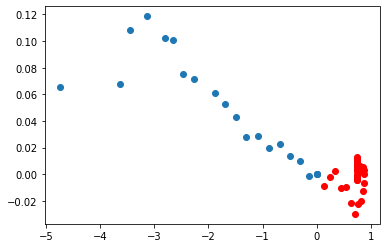

(50, 2)


In [8]:
idx = 100
plt.scatter(train_dataset[idx]['history_positions'][:,0],train_dataset[idx]['history_positions'][:,1])
plt.scatter(train_dataset[idx]['target_positions'][:,0],train_dataset[idx]['target_positions'][:,1],c='r')
plt.show()
print(train_dataset[0]['target_positions'].shape) 

In [9]:
from keras.utils.conv_utils import convert_kernel
from keras.layers import (Input, Conv2D, Flatten,Dense,AveragePooling2D,Dropout,MaxPooling2D,BatchNormalization)
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
from keras.applications.resnet import ResNet101
from tensorflow.keras.applications import EfficientNetB0
base_in = Input(shape=(224,224,num_in_channels))
base_model=Conv2D(22,kernel_size=1,use_bias=False,padding="same")(base_in)
base_model = Dropout(.43)(base_model)
base_model=Conv2D(3,kernel_size=3,use_bias=False,padding="same")(base_model)

efficient_net = EfficientNetB0(include_top=False, 
                               input_tensor=Input(shape=(224, 224, 3)), weights="imagenet")(base_model)
efficient_net.trainable = False
dense_model = Dense(1000, activation="relu")(efficient_net)
dense_model = Dropout(.42)(dense_model)
dense_model=Conv2D(24,kernel_size=3,use_bias=False,padding="same")(dense_model)
dense_model = Dropout(.42)(dense_model)
dense_model=Conv2D(12,kernel_size=3,use_bias=False,padding="same")(dense_model)
dense_model = Dropout(.42)(dense_model)
dense_model=Conv2D(3,kernel_size=3,use_bias=False,padding="same")(dense_model)
resnet_101 = ResNet101(include_top=False,
                       weights='imagenet',
                       input_tensor=Input(shape=(7,7,3)),
                       pooling='max'
                       )(dense_model)
dense_model = Dense(1000, activation="softmax")(resnet_101)
dense_model = Dropout(.42)(dense_model)
dense_model = Dense(num_targets, activation="linear")(dense_model)
model = Model(inputs=base_in, outputs=dense_model)
opt = optimizers.Adam(lr=0.0031)
model.compile(optimizer=opt, loss='mse')

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 45)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 22)      990       
_________________________________________________________________
dropout (Dropout)            (None, 224, 224, 22)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 3)       594       
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
dense (Dense)                (None, 7, 7, 1000)        1281000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 1000)       

I am going to loop through the train_dataset and use a batch_size variable to train the model in batches.  

  0%|          | 0/500 [00:00<?, ?it/s]

2/2 [==============================] - ETA: 0s - loss: 163.2651
Epoch 00001: val_loss improved from inf to 2.01710, saving model to ./model.h5
2/2 [==============================] - 19s 10s/step - loss: 163.2651 - val_loss: 2.0171


  0%|          | 1/500 [00:49<6:52:43, 49.63s/it]

2/2 [==============================] - ETA: 0s - loss: 646.3790
Epoch 00001: val_loss improved from 2.01710 to 2.00927, saving model to ./model.h5
2/2 [==============================] - 15s 7s/step - loss: 646.3790 - val_loss: 2.0093


  0%|          | 2/500 [01:13<5:48:40, 42.01s/it]

2/2 [==============================] - ETA: 0s - loss: 27.4013
Epoch 00001: val_loss improved from 2.00927 to 2.00094, saving model to ./model.h5
2/2 [==============================] - 15s 8s/step - loss: 27.4013 - val_loss: 2.0009


  1%|          | 3/500 [01:38<5:05:31, 36.88s/it]

2/2 [==============================] - ETA: 0s - loss: 59.1658
Epoch 00001: val_loss improved from 2.00094 to 1.99404, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 59.1658 - val_loss: 1.9940


  1%|          | 4/500 [02:06<4:43:10, 34.25s/it]

2/2 [==============================] - ETA: 0s - loss: 9.4538
Epoch 00001: val_loss improved from 1.99404 to 1.98845, saving model to ./model.h5
2/2 [==============================] - 17s 9s/step - loss: 9.4538 - val_loss: 1.9885


  1%|          | 5/500 [02:35<4:28:51, 32.59s/it]

2/2 [==============================] - ETA: 0s - loss: 7.8966
Epoch 00001: val_loss improved from 1.98845 to 1.98397, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 7.8966 - val_loss: 1.9840


  1%|          | 6/500 [03:04<4:19:50, 31.56s/it]

2/2 [==============================] - ETA: 0s - loss: 0.0076
Epoch 00001: val_loss improved from 1.98397 to 1.96705, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 0.0076 - val_loss: 1.9671


  1%|▏         | 7/500 [03:35<4:16:06, 31.17s/it]

2/2 [==============================] - ETA: 0s - loss: 98.0729 
Epoch 00001: val_loss improved from 1.96705 to 1.96148, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 98.0729 - val_loss: 1.9615


  2%|▏         | 8/500 [04:05<4:13:26, 30.91s/it]

2/2 [==============================] - ETA: 0s - loss: 96.2443 
Epoch 00001: val_loss improved from 1.96148 to 1.95632, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 96.2443 - val_loss: 1.9563


  2%|▏         | 9/500 [04:34<4:09:09, 30.45s/it]

2/2 [==============================] - ETA: 0s - loss: 2.7494
Epoch 00001: val_loss improved from 1.95632 to 1.95331, saving model to ./model.h5
2/2 [==============================] - 19s 9s/step - loss: 2.7494 - val_loss: 1.9533


  2%|▏         | 10/500 [05:05<4:08:40, 30.45s/it]

2/2 [==============================] - ETA: 0s - loss: 46.6421
Epoch 00001: val_loss improved from 1.95331 to 1.94952, saving model to ./model.h5
2/2 [==============================] - 17s 9s/step - loss: 46.6421 - val_loss: 1.9495


  2%|▏         | 11/500 [05:34<4:05:06, 30.07s/it]

2/2 [==============================] - ETA: 0s - loss: 69.9507
Epoch 00001: val_loss improved from 1.94952 to 1.94524, saving model to ./model.h5
2/2 [==============================] - 17s 9s/step - loss: 69.9507 - val_loss: 1.9452


  2%|▏         | 12/500 [06:03<4:01:59, 29.75s/it]

2/2 [==============================] - ETA: 0s - loss: 81.4785
Epoch 00001: val_loss improved from 1.94524 to 1.94052, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 81.4785 - val_loss: 1.9405


  3%|▎         | 13/500 [06:32<4:00:16, 29.60s/it]

2/2 [==============================] - ETA: 0s - loss: 46.9529
Epoch 00001: val_loss improved from 1.94052 to 1.93537, saving model to ./model.h5
2/2 [==============================] - 19s 9s/step - loss: 46.9529 - val_loss: 1.9354


  3%|▎         | 14/500 [07:04<4:04:31, 30.19s/it]

2/2 [==============================] - ETA: 0s - loss: 36.0468
Epoch 00001: val_loss improved from 1.93537 to 1.93410, saving model to ./model.h5
2/2 [==============================] - 17s 9s/step - loss: 36.0468 - val_loss: 1.9341


  3%|▎         | 15/500 [07:33<4:02:47, 30.04s/it]

2/2 [==============================] - ETA: 0s - loss: 35.7118
Epoch 00001: val_loss improved from 1.93410 to 1.92653, saving model to ./model.h5
2/2 [==============================] - 17s 9s/step - loss: 35.7118 - val_loss: 1.9265


  3%|▎         | 16/500 [08:02<3:59:24, 29.68s/it]

2/2 [==============================] - ETA: 0s - loss: 36.4455
Epoch 00001: val_loss improved from 1.92653 to 1.91882, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 36.4455 - val_loss: 1.9188


  3%|▎         | 17/500 [08:32<3:58:42, 29.65s/it]

2/2 [==============================] - ETA: 0s - loss: 3.2083
Epoch 00001: val_loss improved from 1.91882 to 1.91221, saving model to ./model.h5
2/2 [==============================] - 17s 9s/step - loss: 3.2083 - val_loss: 1.9122


  4%|▎         | 18/500 [09:01<3:57:40, 29.59s/it]

2/2 [==============================] - ETA: 0s - loss: 0.0393
Epoch 00001: val_loss improved from 1.91221 to 1.90685, saving model to ./model.h5
2/2 [==============================] - 11s 5s/step - loss: 0.0393 - val_loss: 1.9069


  4%|▍         | 19/500 [09:23<3:37:56, 27.19s/it]

2/2 [==============================] - ETA: 0s - loss: 0.0119
Epoch 00001: val_loss improved from 1.90685 to 1.90251, saving model to ./model.h5
2/2 [==============================] - 16s 8s/step - loss: 0.0119 - val_loss: 1.9025


  4%|▍         | 20/500 [09:46<3:27:23, 25.92s/it]

2/2 [==============================] - ETA: 0s - loss: 0.0119
Epoch 00001: val_loss improved from 1.90251 to 1.89896, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 0.0119 - val_loss: 1.8990


  4%|▍         | 21/500 [10:16<3:36:33, 27.13s/it]

2/2 [==============================] - ETA: 0s - loss: 2.6654
Epoch 00001: val_loss improved from 1.89896 to 1.89596, saving model to ./model.h5
2/2 [==============================] - 17s 9s/step - loss: 2.6654 - val_loss: 1.8960


  4%|▍         | 22/500 [10:45<3:41:59, 27.87s/it]

2/2 [==============================] - ETA: 0s - loss: 0.0190
Epoch 00001: val_loss improved from 1.89596 to 1.89352, saving model to ./model.h5
2/2 [==============================] - 17s 9s/step - loss: 0.0190 - val_loss: 1.8935


  5%|▍         | 23/500 [11:14<3:44:40, 28.26s/it]

2/2 [==============================] - ETA: 0s - loss: 0.0165
Epoch 00001: val_loss improved from 1.89352 to 1.89155, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 0.0165 - val_loss: 1.8915


  5%|▍         | 24/500 [11:44<3:46:18, 28.53s/it]

2/2 [==============================] - ETA: 0s - loss: 4.5648
Epoch 00001: val_loss improved from 1.89155 to 1.88994, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 4.5648 - val_loss: 1.8899


  5%|▌         | 25/500 [12:13<3:48:41, 28.89s/it]

2/2 [==============================] - ETA: 0s - loss: 0.0144
Epoch 00001: val_loss improved from 1.88994 to 1.88865, saving model to ./model.h5
2/2 [==============================] - 17s 9s/step - loss: 0.0144 - val_loss: 1.8887


  5%|▌         | 26/500 [12:42<3:47:47, 28.83s/it]

2/2 [==============================] - ETA: 0s - loss: 1.1064
Epoch 00001: val_loss improved from 1.88865 to 1.88760, saving model to ./model.h5
2/2 [==============================] - 17s 9s/step - loss: 1.1064 - val_loss: 1.8876


  5%|▌         | 27/500 [13:11<3:47:11, 28.82s/it]

2/2 [==============================] - ETA: 0s - loss: 23.9343
Epoch 00001: val_loss improved from 1.88760 to 1.88642, saving model to ./model.h5
2/2 [==============================] - 15s 7s/step - loss: 23.9343 - val_loss: 1.8864


  6%|▌         | 28/500 [13:37<3:40:09, 27.99s/it]

2/2 [==============================] - ETA: 0s - loss: 100.7892
Epoch 00001: val_loss improved from 1.88642 to 1.88284, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 100.7892 - val_loss: 1.8828


  6%|▌         | 29/500 [14:06<3:42:58, 28.40s/it]

2/2 [==============================] - ETA: 0s - loss: 48.2373
Epoch 00001: val_loss improved from 1.88284 to 1.87840, saving model to ./model.h5
2/2 [==============================] - 17s 9s/step - loss: 48.2373 - val_loss: 1.8784


  6%|▌         | 30/500 [14:35<3:43:18, 28.51s/it]

2/2 [==============================] - ETA: 0s - loss: 87.2885 
Epoch 00001: val_loss improved from 1.87840 to 1.87339, saving model to ./model.h5
2/2 [==============================] - 15s 7s/step - loss: 87.2885 - val_loss: 1.8734


  6%|▌         | 31/500 [15:01<3:36:25, 27.69s/it]

2/2 [==============================] - ETA: 0s - loss: 85.2816
Epoch 00001: val_loss improved from 1.87339 to 1.86892, saving model to ./model.h5
2/2 [==============================] - 15s 8s/step - loss: 85.2816 - val_loss: 1.8689


  6%|▋         | 32/500 [15:24<3:26:19, 26.45s/it]

2/2 [==============================] - ETA: 0s - loss: 0.0213
Epoch 00001: val_loss improved from 1.86892 to 1.86523, saving model to ./model.h5
2/2 [==============================] - 14s 7s/step - loss: 0.0213 - val_loss: 1.8652


  7%|▋         | 33/500 [15:45<3:13:25, 24.85s/it]

2/2 [==============================] - ETA: 0s - loss: 0.0268
Epoch 00001: val_loss improved from 1.86523 to 1.86229, saving model to ./model.h5
2/2 [==============================] - 12s 6s/step - loss: 0.0268 - val_loss: 1.8623


  7%|▋         | 34/500 [16:06<3:02:13, 23.46s/it]

2/2 [==============================] - ETA: 0s - loss: 60.3808
Epoch 00001: val_loss improved from 1.86229 to 1.85936, saving model to ./model.h5
2/2 [==============================] - 14s 7s/step - loss: 60.3808 - val_loss: 1.8594


  7%|▋         | 35/500 [16:28<2:58:32, 23.04s/it]

2/2 [==============================] - ETA: 0s - loss: 138.2993
Epoch 00001: val_loss improved from 1.85936 to 1.85372, saving model to ./model.h5
2/2 [==============================] - 13s 7s/step - loss: 138.2993 - val_loss: 1.8537


  7%|▋         | 36/500 [16:50<2:55:48, 22.73s/it]

2/2 [==============================] - ETA: 0s - loss: 21.8806
Epoch 00001: val_loss improved from 1.85372 to 1.84797, saving model to ./model.h5
2/2 [==============================] - 11s 5s/step - loss: 21.8806 - val_loss: 1.8480


  7%|▋         | 37/500 [17:08<2:44:56, 21.37s/it]

2/2 [==============================] - ETA: 0s - loss: 4.3394
Epoch 00001: val_loss improved from 1.84797 to 1.84234, saving model to ./model.h5
2/2 [==============================] - 15s 8s/step - loss: 4.3394 - val_loss: 1.8423


  8%|▊         | 38/500 [17:31<2:47:45, 21.79s/it]

2/2 [==============================] - ETA: 0s - loss: 12.2678
Epoch 00001: val_loss improved from 1.84234 to 1.83734, saving model to ./model.h5
2/2 [==============================] - 15s 8s/step - loss: 12.2678 - val_loss: 1.8373


  8%|▊         | 39/500 [17:55<2:52:36, 22.47s/it]

2/2 [==============================] - ETA: 0s - loss: 32.5304
Epoch 00001: val_loss improved from 1.83734 to 1.83275, saving model to ./model.h5
2/2 [==============================] - 15s 7s/step - loss: 32.5304 - val_loss: 1.8328


  8%|▊         | 40/500 [18:20<2:59:40, 23.44s/it]

2/2 [==============================] - ETA: 0s - loss: 182.7031
Epoch 00001: val_loss improved from 1.83275 to 1.82781, saving model to ./model.h5
2/2 [==============================] - 15s 7s/step - loss: 182.7031 - val_loss: 1.8278


  8%|▊         | 41/500 [18:44<3:00:36, 23.61s/it]

2/2 [==============================] - ETA: 0s - loss: 223.1811
Epoch 00001: val_loss improved from 1.82781 to 1.82232, saving model to ./model.h5
2/2 [==============================] - 13s 7s/step - loss: 223.1811 - val_loss: 1.8223


  8%|▊         | 42/500 [19:09<3:01:21, 23.76s/it]

2/2 [==============================] - ETA: 0s - loss: 216.9714
Epoch 00001: val_loss improved from 1.82232 to 1.81664, saving model to ./model.h5
2/2 [==============================] - 12s 6s/step - loss: 216.9714 - val_loss: 1.8166


  9%|▊         | 43/500 [19:30<2:54:54, 22.96s/it]

2/2 [==============================] - ETA: 0s - loss: 16.8477
Epoch 00001: val_loss improved from 1.81664 to 1.81106, saving model to ./model.h5
2/2 [==============================] - 15s 7s/step - loss: 16.8477 - val_loss: 1.8111


  9%|▉         | 44/500 [19:52<2:53:36, 22.84s/it]

2/2 [==============================] - ETA: 0s - loss: 3.4929
Epoch 00001: val_loss improved from 1.81106 to 1.80642, saving model to ./model.h5
2/2 [==============================] - 15s 7s/step - loss: 3.4929 - val_loss: 1.8064


  9%|▉         | 45/500 [20:15<2:53:20, 22.86s/it]

2/2 [==============================] - ETA: 0s - loss: 0.0602
Epoch 00001: val_loss improved from 1.80642 to 1.80265, saving model to ./model.h5
2/2 [==============================] - 13s 7s/step - loss: 0.0602 - val_loss: 1.8027


  9%|▉         | 46/500 [20:39<2:54:13, 23.02s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2207
Epoch 00001: val_loss improved from 1.80265 to 1.80138, saving model to ./model.h5
2/2 [==============================] - 16s 8s/step - loss: 0.2207 - val_loss: 1.8014


  9%|▉         | 47/500 [21:04<2:58:49, 23.69s/it]

2/2 [==============================] - ETA: 0s - loss: 0.4695
Epoch 00001: val_loss improved from 1.80138 to 1.79813, saving model to ./model.h5
2/2 [==============================] - 16s 8s/step - loss: 0.4695 - val_loss: 1.7981


 10%|▉         | 48/500 [21:28<3:00:04, 23.90s/it]

2/2 [==============================] - ETA: 0s - loss: 0.1908
Epoch 00001: val_loss improved from 1.79813 to 1.79542, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 0.1908 - val_loss: 1.7954


 10%|▉         | 49/500 [21:58<3:13:31, 25.75s/it]

2/2 [==============================] - ETA: 0s - loss: 0.0610
Epoch 00001: val_loss improved from 1.79542 to 1.79320, saving model to ./model.h5
2/2 [==============================] - 17s 9s/step - loss: 0.0610 - val_loss: 1.7932


 10%|█         | 50/500 [22:27<3:19:01, 26.54s/it]

2/2 [==============================] - ETA: 0s - loss: 0.0603
Epoch 00001: val_loss improved from 1.79320 to 1.79141, saving model to ./model.h5
2/2 [==============================] - 19s 9s/step - loss: 0.0603 - val_loss: 1.7914


 10%|█         | 51/500 [22:55<3:23:18, 27.17s/it]

2/2 [==============================] - ETA: 0s - loss: 16.6779
Epoch 00001: val_loss improved from 1.79141 to 1.78881, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 16.6779 - val_loss: 1.7888


 10%|█         | 52/500 [23:25<3:28:17, 27.90s/it]

2/2 [==============================] - ETA: 0s - loss: 28.4926
Epoch 00001: val_loss improved from 1.78881 to 1.78547, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 28.4926 - val_loss: 1.7855


 11%|█         | 53/500 [23:55<3:31:50, 28.43s/it]

2/2 [==============================] - ETA: 0s - loss: 19.3517
Epoch 00001: val_loss improved from 1.78547 to 1.78159, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 19.3517 - val_loss: 1.7816


 11%|█         | 54/500 [24:25<3:35:02, 28.93s/it]

2/2 [==============================] - ETA: 0s - loss: 65.6870
Epoch 00001: val_loss improved from 1.78159 to 1.77788, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 65.6870 - val_loss: 1.7779


 11%|█         | 55/500 [24:55<3:37:40, 29.35s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2001
Epoch 00001: val_loss improved from 1.77788 to 1.77466, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 0.2001 - val_loss: 1.7747


 11%|█         | 56/500 [25:25<3:38:13, 29.49s/it]

2/2 [==============================] - ETA: 0s - loss: 43.6420
Epoch 00001: val_loss improved from 1.77466 to 1.77095, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 43.6420 - val_loss: 1.7709


 11%|█▏        | 57/500 [25:55<3:38:33, 29.60s/it]

2/2 [==============================] - ETA: 0s - loss: 96.4649
Epoch 00001: val_loss improved from 1.77095 to 1.76586, saving model to ./model.h5
2/2 [==============================] - 15s 8s/step - loss: 96.4649 - val_loss: 1.7659


 12%|█▏        | 58/500 [26:22<3:32:27, 28.84s/it]

2/2 [==============================] - ETA: 0s - loss: 195.2069
Epoch 00001: val_loss improved from 1.76586 to 1.75990, saving model to ./model.h5
2/2 [==============================] - 13s 7s/step - loss: 195.2069 - val_loss: 1.7599


 12%|█▏        | 59/500 [26:46<3:21:34, 27.43s/it]

2/2 [==============================] - ETA: 0s - loss: 174.0002
Epoch 00001: val_loss improved from 1.75990 to 1.75240, saving model to ./model.h5
2/2 [==============================] - 16s 8s/step - loss: 174.0002 - val_loss: 1.7524


 12%|█▏        | 60/500 [27:14<3:22:31, 27.62s/it]

2/2 [==============================] - ETA: 0s - loss: 0.6749
Epoch 00001: val_loss improved from 1.75240 to 1.74643, saving model to ./model.h5
2/2 [==============================] - 11s 6s/step - loss: 0.6749 - val_loss: 1.7464


 12%|█▏        | 61/500 [27:35<3:07:11, 25.58s/it]

2/2 [==============================] - ETA: 0s - loss: 26.6763
Epoch 00001: val_loss improved from 1.74643 to 1.74160, saving model to ./model.h5
2/2 [==============================] - 15s 8s/step - loss: 26.6763 - val_loss: 1.7416


 12%|█▏        | 62/500 [27:58<3:02:10, 24.96s/it]

2/2 [==============================] - ETA: 0s - loss: 0.6364
Epoch 00001: val_loss improved from 1.74160 to 1.73780, saving model to ./model.h5
2/2 [==============================] - 14s 7s/step - loss: 0.6364 - val_loss: 1.7378


 13%|█▎        | 63/500 [28:22<2:59:18, 24.62s/it]

2/2 [==============================] - ETA: 0s - loss: 0.5540
Epoch 00001: val_loss improved from 1.73780 to 1.73491, saving model to ./model.h5
2/2 [==============================] - 12s 6s/step - loss: 0.5540 - val_loss: 1.7349


 13%|█▎        | 64/500 [28:42<2:49:26, 23.32s/it]

2/2 [==============================] - ETA: 0s - loss: 0.4876
Epoch 00001: val_loss improved from 1.73491 to 1.73275, saving model to ./model.h5
2/2 [==============================] - 12s 6s/step - loss: 0.4876 - val_loss: 1.7327


 13%|█▎        | 65/500 [29:03<2:43:36, 22.57s/it]

2/2 [==============================] - ETA: 0s - loss: 131.5317
Epoch 00001: val_loss improved from 1.73275 to 1.73003, saving model to ./model.h5
2/2 [==============================] - 15s 8s/step - loss: 131.5317 - val_loss: 1.7300


 13%|█▎        | 66/500 [29:28<2:47:33, 23.16s/it]

2/2 [==============================] - ETA: 0s - loss: 3.5006
Epoch 00001: val_loss improved from 1.73003 to 1.72766, saving model to ./model.h5
2/2 [==============================] - 13s 6s/step - loss: 3.5006 - val_loss: 1.7277


 13%|█▎        | 67/500 [29:49<2:43:21, 22.64s/it]

2/2 [==============================] - ETA: 0s - loss: 59.7211
Epoch 00001: val_loss improved from 1.72766 to 1.72532, saving model to ./model.h5
2/2 [==============================] - 14s 7s/step - loss: 59.7211 - val_loss: 1.7253


 14%|█▎        | 68/500 [30:12<2:44:32, 22.85s/it]

2/2 [==============================] - ETA: 0s - loss: 10.8424
Epoch 00001: val_loss improved from 1.72532 to 1.72314, saving model to ./model.h5
2/2 [==============================] - 17s 9s/step - loss: 10.8424 - val_loss: 1.7231


 14%|█▍        | 69/500 [30:40<2:54:52, 24.34s/it]

2/2 [==============================] - ETA: 0s - loss: 45.3906
Epoch 00001: val_loss improved from 1.72314 to 1.72101, saving model to ./model.h5
2/2 [==============================] - 12s 6s/step - loss: 45.3906 - val_loss: 1.7210


 14%|█▍        | 70/500 [31:02<2:48:37, 23.53s/it]

2/2 [==============================] - ETA: 0s - loss: 215.4548
Epoch 00001: val_loss improved from 1.72101 to 1.71724, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 215.4548 - val_loss: 1.7172


 14%|█▍        | 71/500 [31:28<2:53:00, 24.20s/it]

2/2 [==============================] - ETA: 0s - loss: 10.0571
Epoch 00001: val_loss improved from 1.71724 to 1.71378, saving model to ./model.h5
2/2 [==============================] - 16s 8s/step - loss: 10.0571 - val_loss: 1.7138


 14%|█▍        | 72/500 [31:53<2:54:15, 24.43s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2076
Epoch 00001: val_loss improved from 1.71378 to 1.71102, saving model to ./model.h5
2/2 [==============================] - 19s 9s/step - loss: 0.2076 - val_loss: 1.7110


 15%|█▍        | 73/500 [32:23<3:06:15, 26.17s/it]

2/2 [==============================] - ETA: 0s - loss: 0.0956
Epoch 00001: val_loss improved from 1.71102 to 1.70887, saving model to ./model.h5
2/2 [==============================] - 12s 6s/step - loss: 0.0956 - val_loss: 1.7089


 15%|█▍        | 74/500 [32:44<2:54:27, 24.57s/it]

2/2 [==============================] - ETA: 0s - loss: 4.5642
Epoch 00001: val_loss improved from 1.70887 to 1.70708, saving model to ./model.h5
2/2 [==============================] - 14s 7s/step - loss: 4.5642 - val_loss: 1.7071


 15%|█▌        | 75/500 [33:05<2:47:32, 23.65s/it]

2/2 [==============================] - ETA: 0s - loss: 7.0401
Epoch 00001: val_loss improved from 1.70708 to 1.70525, saving model to ./model.h5
2/2 [==============================] - 12s 6s/step - loss: 7.0401 - val_loss: 1.7053


 15%|█▌        | 76/500 [33:26<2:40:23, 22.70s/it]

2/2 [==============================] - ETA: 0s - loss: 8.1014
Epoch 00001: val_loss improved from 1.70525 to 1.70320, saving model to ./model.h5
2/2 [==============================] - 13s 7s/step - loss: 8.1014 - val_loss: 1.7032


 15%|█▌        | 77/500 [33:47<2:37:02, 22.28s/it]

2/2 [==============================] - ETA: 0s - loss: 9.2343
Epoch 00001: val_loss improved from 1.70320 to 1.70107, saving model to ./model.h5
2/2 [==============================] - 14s 7s/step - loss: 9.2343 - val_loss: 1.7011


 16%|█▌        | 78/500 [34:09<2:36:52, 22.31s/it]

2/2 [==============================] - ETA: 0s - loss: 10.1426
Epoch 00001: val_loss improved from 1.70107 to 1.69923, saving model to ./model.h5
2/2 [==============================] - 15s 8s/step - loss: 10.1426 - val_loss: 1.6992


 16%|█▌        | 79/500 [34:33<2:40:06, 22.82s/it]

2/2 [==============================] - ETA: 0s - loss: 16.3063
Epoch 00001: val_loss improved from 1.69923 to 1.69752, saving model to ./model.h5
2/2 [==============================] - 19s 9s/step - loss: 16.3063 - val_loss: 1.6975


 16%|█▌        | 80/500 [35:03<2:54:48, 24.97s/it]

2/2 [==============================] - ETA: 0s - loss: 27.5937
Epoch 00001: val_loss improved from 1.69752 to 1.69591, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 27.5937 - val_loss: 1.6959


 16%|█▌        | 81/500 [35:33<3:03:18, 26.25s/it]

2/2 [==============================] - ETA: 0s - loss: 61.1341
Epoch 00001: val_loss improved from 1.69591 to 1.69411, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 61.1341 - val_loss: 1.6941


 16%|█▋        | 82/500 [36:02<3:09:16, 27.17s/it]

2/2 [==============================] - ETA: 0s - loss: 125.8657
Epoch 00001: val_loss improved from 1.69411 to 1.69179, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 125.8657 - val_loss: 1.6918


 17%|█▋        | 83/500 [36:31<3:13:26, 27.83s/it]

2/2 [==============================] - ETA: 0s - loss: 27.9541
Epoch 00001: val_loss improved from 1.69179 to 1.68979, saving model to ./model.h5
2/2 [==============================] - 17s 9s/step - loss: 27.9541 - val_loss: 1.6898


 17%|█▋        | 84/500 [36:58<3:10:46, 27.51s/it]

2/2 [==============================] - ETA: 0s - loss: 93.5875 
Epoch 00001: val_loss improved from 1.68979 to 1.68786, saving model to ./model.h5
2/2 [==============================] - 11s 6s/step - loss: 93.5875 - val_loss: 1.6879


 17%|█▋        | 85/500 [37:19<2:57:33, 25.67s/it]

2/2 [==============================] - ETA: 0s - loss: 39.6018
Epoch 00001: val_loss improved from 1.68786 to 1.68618, saving model to ./model.h5
2/2 [==============================] - 13s 7s/step - loss: 39.6018 - val_loss: 1.6862


 17%|█▋        | 86/500 [37:44<2:55:12, 25.39s/it]

2/2 [==============================] - ETA: 0s - loss: 0.5155
Epoch 00001: val_loss improved from 1.68618 to 1.68502, saving model to ./model.h5
2/2 [==============================] - 11s 5s/step - loss: 0.5155 - val_loss: 1.6850


 17%|█▋        | 87/500 [38:02<2:39:27, 23.17s/it]

2/2 [==============================] - ETA: 0s - loss: 0.5604
Epoch 00001: val_loss improved from 1.68502 to 1.68431, saving model to ./model.h5
2/2 [==============================] - 11s 5s/step - loss: 0.5604 - val_loss: 1.6843


 18%|█▊        | 88/500 [38:20<2:28:41, 21.65s/it]

2/2 [==============================] - ETA: 0s - loss: 0.6659
Epoch 00001: val_loss improved from 1.68431 to 1.68396, saving model to ./model.h5
2/2 [==============================] - 11s 5s/step - loss: 0.6659 - val_loss: 1.6840


 18%|█▊        | 89/500 [38:40<2:23:28, 20.95s/it]

2/2 [==============================] - ETA: 0s - loss: 0.9186
Epoch 00001: val_loss improved from 1.68396 to 1.68389, saving model to ./model.h5
2/2 [==============================] - 11s 6s/step - loss: 0.9186 - val_loss: 1.6839


 18%|█▊        | 90/500 [38:58<2:18:05, 20.21s/it]

2/2 [==============================] - ETA: 0s - loss: 12.5018
Epoch 00001: val_loss did not improve from 1.68389
2/2 [==============================] - 10s 5s/step - loss: 12.5018 - val_loss: 1.6841


 18%|█▊        | 91/500 [39:16<2:12:42, 19.47s/it]

2/2 [==============================] - ETA: 0s - loss: 71.5360
Epoch 00001: val_loss did not improve from 1.68389
2/2 [==============================] - 10s 5s/step - loss: 71.5360 - val_loss: 1.6842


 18%|█▊        | 92/500 [39:34<2:09:06, 18.99s/it]

2/2 [==============================] - ETA: 0s - loss: 138.1450
Epoch 00001: val_loss improved from 1.68389 to 1.68249, saving model to ./model.h5
2/2 [==============================] - 15s 8s/step - loss: 138.1450 - val_loss: 1.6825


 19%|█▊        | 93/500 [39:56<2:16:34, 20.13s/it]

2/2 [==============================] - ETA: 0s - loss: 165.5236
Epoch 00001: val_loss improved from 1.68249 to 1.67881, saving model to ./model.h5
2/2 [==============================] - 20s 10s/step - loss: 165.5236 - val_loss: 1.6788


 19%|█▉        | 94/500 [40:29<2:42:03, 23.95s/it]

2/2 [==============================] - ETA: 0s - loss: 110.6747
Epoch 00001: val_loss improved from 1.67881 to 1.67481, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 110.6747 - val_loss: 1.6748


 19%|█▉        | 95/500 [40:59<2:54:07, 25.80s/it]

2/2 [==============================] - ETA: 0s - loss: 42.7196
Epoch 00001: val_loss improved from 1.67481 to 1.67099, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 42.7196 - val_loss: 1.6710


 19%|█▉        | 96/500 [41:30<3:02:29, 27.10s/it]

2/2 [==============================] - ETA: 0s - loss: 14.5410
Epoch 00001: val_loss improved from 1.67099 to 1.66768, saving model to ./model.h5
2/2 [==============================] - 19s 10s/step - loss: 14.5410 - val_loss: 1.6677


 19%|█▉        | 97/500 [42:01<3:10:26, 28.35s/it]

2/2 [==============================] - ETA: 0s - loss: 2.2089
Epoch 00001: val_loss improved from 1.66768 to 1.66495, saving model to ./model.h5
2/2 [==============================] - 17s 9s/step - loss: 2.2089 - val_loss: 1.6649


 20%|█▉        | 98/500 [42:29<3:08:51, 28.19s/it]

2/2 [==============================] - ETA: 0s - loss: 0.3421
Epoch 00001: val_loss improved from 1.66495 to 1.66274, saving model to ./model.h5
2/2 [==============================] - 19s 9s/step - loss: 0.3421 - val_loss: 1.6627


 20%|█▉        | 99/500 [43:00<3:13:42, 28.98s/it]

2/2 [==============================] - ETA: 0s - loss: 0.3593
Epoch 00001: val_loss improved from 1.66274 to 1.66099, saving model to ./model.h5
2/2 [==============================] - 12s 6s/step - loss: 0.3593 - val_loss: 1.6610


 20%|██        | 100/500 [43:21<2:57:44, 26.66s/it]

2/2 [==============================] - ETA: 0s - loss: 0.5952
Epoch 00001: val_loss improved from 1.66099 to 1.65967, saving model to ./model.h5
2/2 [==============================] - 19s 10s/step - loss: 0.5952 - val_loss: 1.6597


 20%|██        | 101/500 [43:52<3:07:11, 28.15s/it]

2/2 [==============================] - ETA: 0s - loss: 0.6360
Epoch 00001: val_loss improved from 1.65967 to 1.65870, saving model to ./model.h5
2/2 [==============================] - 12s 6s/step - loss: 0.6360 - val_loss: 1.6587


 20%|██        | 102/500 [44:15<2:56:39, 26.63s/it]

2/2 [==============================] - ETA: 0s - loss: 11.7880
Epoch 00001: val_loss improved from 1.65870 to 1.65711, saving model to ./model.h5
2/2 [==============================] - 12s 6s/step - loss: 11.7880 - val_loss: 1.6571


 21%|██        | 103/500 [44:35<2:42:20, 24.54s/it]

2/2 [==============================] - ETA: 0s - loss: 47.9896
Epoch 00001: val_loss improved from 1.65711 to 1.65512, saving model to ./model.h5
2/2 [==============================] - 11s 6s/step - loss: 47.9896 - val_loss: 1.6551


 21%|██        | 104/500 [44:54<2:31:21, 22.93s/it]

2/2 [==============================] - ETA: 0s - loss: 0.6000
Epoch 00001: val_loss improved from 1.65512 to 1.65308, saving model to ./model.h5
2/2 [==============================] - 14s 7s/step - loss: 0.6000 - val_loss: 1.6531


 21%|██        | 105/500 [45:17<2:29:39, 22.73s/it]

2/2 [==============================] - ETA: 0s - loss: 0.5763
Epoch 00001: val_loss improved from 1.65308 to 1.65143, saving model to ./model.h5
2/2 [==============================] - 13s 7s/step - loss: 0.5763 - val_loss: 1.6514


 21%|██        | 106/500 [45:39<2:29:33, 22.78s/it]

2/2 [==============================] - ETA: 0s - loss: 12.6944
Epoch 00001: val_loss improved from 1.65143 to 1.65013, saving model to ./model.h5
2/2 [==============================] - 17s 8s/step - loss: 12.6944 - val_loss: 1.6501


 21%|██▏       | 107/500 [46:06<2:37:34, 24.06s/it]

2/2 [==============================] - ETA: 0s - loss: 0.7251
Epoch 00001: val_loss improved from 1.65013 to 1.64915, saving model to ./model.h5
2/2 [==============================] - 13s 7s/step - loss: 0.7251 - val_loss: 1.6492


 22%|██▏       | 108/500 [46:30<2:36:52, 24.01s/it]

2/2 [==============================] - ETA: 0s - loss: 0.5748
Epoch 00001: val_loss improved from 1.64915 to 1.64845, saving model to ./model.h5
2/2 [==============================] - 13s 6s/step - loss: 0.5748 - val_loss: 1.6484


 22%|██▏       | 109/500 [46:53<2:33:04, 23.49s/it]

2/2 [==============================] - ETA: 0s - loss: 40.2969
Epoch 00001: val_loss improved from 1.64845 to 1.64767, saving model to ./model.h5
2/2 [==============================] - 19s 10s/step - loss: 40.2969 - val_loss: 1.6477


 22%|██▏       | 110/500 [47:22<2:43:23, 25.14s/it]

2/2 [==============================] - ETA: 0s - loss: 26.4574
Epoch 00001: val_loss improved from 1.64767 to 1.64687, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 26.4574 - val_loss: 1.6469


 22%|██▏       | 111/500 [47:52<2:52:32, 26.61s/it]

2/2 [==============================] - ETA: 0s - loss: 11.8415
Epoch 00001: val_loss improved from 1.64687 to 1.64615, saving model to ./model.h5
2/2 [==============================] - 19s 9s/step - loss: 11.8415 - val_loss: 1.6462


 22%|██▏       | 112/500 [48:22<2:59:50, 27.81s/it]

2/2 [==============================] - ETA: 0s - loss: 2.8869
Epoch 00001: val_loss improved from 1.64615 to 1.64554, saving model to ./model.h5
2/2 [==============================] - 12s 6s/step - loss: 2.8869 - val_loss: 1.6455


 23%|██▎       | 113/500 [48:44<2:47:16, 25.93s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2050
Epoch 00001: val_loss improved from 1.64554 to 1.64505, saving model to ./model.h5
2/2 [==============================] - 16s 8s/step - loss: 0.2050 - val_loss: 1.6451


 23%|██▎       | 114/500 [49:09<2:44:56, 25.64s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2208
Epoch 00001: val_loss improved from 1.64505 to 1.64469, saving model to ./model.h5
2/2 [==============================] - 15s 7s/step - loss: 0.2208 - val_loss: 1.6447


 23%|██▎       | 115/500 [49:33<2:41:08, 25.11s/it]

2/2 [==============================] - ETA: 0s - loss: 1.6482
Epoch 00001: val_loss improved from 1.64469 to 1.64436, saving model to ./model.h5
2/2 [==============================] - 14s 7s/step - loss: 1.6482 - val_loss: 1.6444


 23%|██▎       | 116/500 [49:57<2:38:37, 24.78s/it]

2/2 [==============================] - ETA: 0s - loss: 1.2861
Epoch 00001: val_loss improved from 1.64436 to 1.64406, saving model to ./model.h5
2/2 [==============================] - 15s 7s/step - loss: 1.2861 - val_loss: 1.6441


 23%|██▎       | 117/500 [50:22<2:38:16, 24.80s/it]

2/2 [==============================] - ETA: 0s - loss: 1.0816
Epoch 00001: val_loss improved from 1.64406 to 1.64374, saving model to ./model.h5
2/2 [==============================] - 19s 9s/step - loss: 1.0816 - val_loss: 1.6437


 24%|██▎       | 118/500 [50:53<2:51:16, 26.90s/it]

2/2 [==============================] - ETA: 0s - loss: 1.0910
Epoch 00001: val_loss improved from 1.64374 to 1.64345, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 1.0910 - val_loss: 1.6434


 24%|██▍       | 119/500 [51:24<2:58:12, 28.06s/it]

2/2 [==============================] - ETA: 0s - loss: 1.4340
Epoch 00001: val_loss improved from 1.64345 to 1.64322, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 1.4340 - val_loss: 1.6432


 24%|██▍       | 120/500 [51:55<3:02:47, 28.86s/it]

2/2 [==============================] - ETA: 0s - loss: 2.2932
Epoch 00001: val_loss improved from 1.64322 to 1.64303, saving model to ./model.h5
2/2 [==============================] - 19s 10s/step - loss: 2.2932 - val_loss: 1.6430


 24%|██▍       | 121/500 [52:26<3:07:28, 29.68s/it]

2/2 [==============================] - ETA: 0s - loss: 3.2424
Epoch 00001: val_loss improved from 1.64303 to 1.58209, saving model to ./model.h5
2/2 [==============================] - 18s 9s/step - loss: 3.2424 - val_loss: 1.5821


 24%|██▍       | 122/500 [52:58<3:10:02, 30.16s/it]

2/2 [==============================] - ETA: 0s - loss: 4.2656
Epoch 00001: val_loss did not improve from 1.58209
2/2 [==============================] - 17s 9s/step - loss: 4.2656 - val_loss: 1.6106


 25%|██▍       | 123/500 [53:28<3:09:18, 30.13s/it]

2/2 [==============================] - ETA: 0s - loss: 4.9185
Epoch 00001: val_loss did not improve from 1.58209
2/2 [==============================] - 17s 9s/step - loss: 4.9185 - val_loss: 1.6094


 25%|██▍       | 124/500 [53:58<3:09:25, 30.23s/it]

2/2 [==============================] - ETA: 0s - loss: 4.8497
Epoch 00001: val_loss did not improve from 1.58209
2/2 [==============================] - 18s 9s/step - loss: 4.8497 - val_loss: 1.6083


 25%|██▌       | 125/500 [54:29<3:10:21, 30.46s/it]

2/2 [==============================] - ETA: 0s - loss: 6.3645
Epoch 00001: val_loss did not improve from 1.58209
2/2 [==============================] - 14s 7s/step - loss: 6.3645 - val_loss: 1.6069


 25%|██▌       | 126/500 [54:55<3:01:42, 29.15s/it]

2/2 [==============================] - ETA: 0s - loss: 9.2173
Epoch 00001: val_loss did not improve from 1.58209
2/2 [==============================] - 12s 6s/step - loss: 9.2173 - val_loss: 1.6054


 25%|██▌       | 127/500 [55:17<2:46:24, 26.77s/it]

2/2 [==============================] - ETA: 0s - loss: 7.3684
Epoch 00001: val_loss did not improve from 1.58209
2/2 [==============================] - 11s 6s/step - loss: 7.3684 - val_loss: 1.6036


 26%|██▌       | 128/500 [55:36<2:32:56, 24.67s/it]

2/2 [==============================] - ETA: 0s - loss: 0.4508
Epoch 00001: val_loss did not improve from 1.58209
2/2 [==============================] - 11s 6s/step - loss: 0.4508 - val_loss: 1.6018


 26%|██▌       | 129/500 [55:56<2:23:27, 23.20s/it]

2/2 [==============================] - ETA: 0s - loss: 0.4707
Epoch 00001: val_loss did not improve from 1.58209
2/2 [==============================] - 11s 6s/step - loss: 0.4707 - val_loss: 1.5987


 26%|██▌       | 130/500 [56:18<2:20:49, 22.84s/it]

2/2 [==============================] - ETA: 0s - loss: 0.5623
Epoch 00001: val_loss did not improve from 1.58209
2/2 [==============================] - 12s 6s/step - loss: 0.5623 - val_loss: 1.5831


 26%|██▌       | 131/500 [56:41<2:20:08, 22.79s/it]

2/2 [==============================] - ETA: 0s - loss: 0.5162
Epoch 00001: val_loss improved from 1.58209 to 1.57693, saving model to ./model.h5
2/2 [==============================] - 15s 7s/step - loss: 0.5162 - val_loss: 1.5769


 26%|██▋       | 132/500 [57:06<2:23:42, 23.43s/it]

2/2 [==============================] - ETA: 0s - loss: 8.6332 
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 9s/step - loss: 8.6332 - val_loss: 1.5990


 27%|██▋       | 133/500 [57:37<2:37:50, 25.81s/it]

2/2 [==============================] - ETA: 0s - loss: 128.4605
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 9s/step - loss: 128.4605 - val_loss: 1.5959


 27%|██▋       | 134/500 [58:09<2:49:03, 27.72s/it]

2/2 [==============================] - ETA: 0s - loss: 41.9277
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 9s/step - loss: 41.9277 - val_loss: 1.6313


 27%|██▋       | 135/500 [58:41<2:55:24, 28.84s/it]

2/2 [==============================] - ETA: 0s - loss: 27.8711
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 9s/step - loss: 27.8711 - val_loss: 1.6279


 27%|██▋       | 136/500 [59:12<2:59:14, 29.55s/it]

2/2 [==============================] - ETA: 0s - loss: 9.1670 
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 9s/step - loss: 9.1670 - val_loss: 1.6251


 27%|██▋       | 137/500 [59:44<3:02:36, 30.18s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2316
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 8s/step - loss: 0.2316 - val_loss: 1.6228


 28%|██▊       | 138/500 [1:00:14<3:02:33, 30.26s/it]

2/2 [==============================] - ETA: 0s - loss: 0.3436
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 8s/step - loss: 0.3436 - val_loss: 1.6211


 28%|██▊       | 139/500 [1:00:45<3:03:01, 30.42s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2358
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 18s 9s/step - loss: 0.2358 - val_loss: 1.6198


 28%|██▊       | 140/500 [1:01:17<3:05:20, 30.89s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2070
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 8s/step - loss: 0.2070 - val_loss: 1.6188


 28%|██▊       | 141/500 [1:01:47<3:03:44, 30.71s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2006
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 9s/step - loss: 0.2006 - val_loss: 1.6181


 28%|██▊       | 142/500 [1:02:18<3:02:55, 30.66s/it]

2/2 [==============================] - ETA: 0s - loss: 8.8846
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 8s/step - loss: 8.8846 - val_loss: 1.6175


 29%|██▊       | 143/500 [1:02:48<3:01:46, 30.55s/it]

2/2 [==============================] - ETA: 0s - loss: 27.0719
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 8s/step - loss: 27.0719 - val_loss: 1.6167


 29%|██▉       | 144/500 [1:03:20<3:03:30, 30.93s/it]

2/2 [==============================] - ETA: 0s - loss: 23.5608
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 9s/step - loss: 23.5608 - val_loss: 1.6157


 29%|██▉       | 145/500 [1:03:50<3:02:13, 30.80s/it]

2/2 [==============================] - ETA: 0s - loss: 28.8356
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 9s/step - loss: 28.8356 - val_loss: 1.6142


 29%|██▉       | 146/500 [1:04:22<3:02:40, 30.96s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2070
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 18s 9s/step - loss: 0.2070 - val_loss: 1.6126


 29%|██▉       | 147/500 [1:04:53<3:03:18, 31.16s/it]

2/2 [==============================] - ETA: 0s - loss: 19.9909
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 9s/step - loss: 19.9909 - val_loss: 1.6112


 30%|██▉       | 148/500 [1:05:24<3:01:26, 30.93s/it]

2/2 [==============================] - ETA: 0s - loss: 25.8119
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 8s/step - loss: 25.8119 - val_loss: 1.6097


 30%|██▉       | 149/500 [1:05:54<2:59:33, 30.69s/it]

2/2 [==============================] - ETA: 0s - loss: 19.1790
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 18s 9s/step - loss: 19.1790 - val_loss: 1.6084


 30%|███       | 150/500 [1:06:25<2:59:23, 30.75s/it]

2/2 [==============================] - ETA: 0s - loss: 23.3117
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 9s/step - loss: 23.3117 - val_loss: 1.6067


 30%|███       | 151/500 [1:06:56<3:00:06, 30.96s/it]

2/2 [==============================] - ETA: 0s - loss: 22.4780
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 9s/step - loss: 22.4780 - val_loss: 1.6047


 30%|███       | 152/500 [1:07:26<2:58:12, 30.73s/it]

2/2 [==============================] - ETA: 0s - loss: 17.5204
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 9s/step - loss: 17.5204 - val_loss: 1.6028


 31%|███       | 153/500 [1:07:56<2:56:31, 30.52s/it]

2/2 [==============================] - ETA: 0s - loss: 0.1795
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 18s 9s/step - loss: 0.1795 - val_loss: 1.6013


 31%|███       | 154/500 [1:08:28<2:57:34, 30.79s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2008
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 9s/step - loss: 0.2008 - val_loss: 1.6001


 31%|███       | 155/500 [1:08:58<2:56:38, 30.72s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2182
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 9s/step - loss: 0.2182 - val_loss: 1.5993


 31%|███       | 156/500 [1:09:29<2:55:41, 30.64s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2016
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 18s 9s/step - loss: 0.2016 - val_loss: 1.5987


 31%|███▏      | 157/500 [1:10:00<2:56:55, 30.95s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2088
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 9s/step - loss: 0.2088 - val_loss: 1.5983


 32%|███▏      | 158/500 [1:10:31<2:55:18, 30.75s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2024
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 9s/step - loss: 0.2024 - val_loss: 1.5981


 32%|███▏      | 159/500 [1:11:01<2:53:59, 30.62s/it]

2/2 [==============================] - ETA: 0s - loss: 2.6457
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 18s 9s/step - loss: 2.6457 - val_loss: 1.5979


 32%|███▏      | 160/500 [1:11:32<2:53:37, 30.64s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2081
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 18s 9s/step - loss: 0.2081 - val_loss: 1.5978


 32%|███▏      | 161/500 [1:12:03<2:54:09, 30.82s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2349
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 9s/step - loss: 0.2349 - val_loss: 1.5979


 32%|███▏      | 162/500 [1:12:34<2:53:43, 30.84s/it]

2/2 [==============================] - ETA: 0s - loss: 12.5043
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 9s/step - loss: 12.5043 - val_loss: 1.5980


 33%|███▎      | 163/500 [1:13:05<2:53:48, 30.95s/it]

2/2 [==============================] - ETA: 0s - loss: 22.8047
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 18s 9s/step - loss: 22.8047 - val_loss: 1.5979


 33%|███▎      | 164/500 [1:13:36<2:54:09, 31.10s/it]

2/2 [==============================] - ETA: 0s - loss: 31.9941
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 8s/step - loss: 31.9941 - val_loss: 1.5974


 33%|███▎      | 165/500 [1:14:07<2:52:44, 30.94s/it]

2/2 [==============================] - ETA: 0s - loss: 28.4391
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 8s/step - loss: 28.4391 - val_loss: 1.5965


 33%|███▎      | 166/500 [1:14:37<2:51:06, 30.74s/it]

2/2 [==============================] - ETA: 0s - loss: 14.5297
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 9s/step - loss: 14.5297 - val_loss: 1.5956


 33%|███▎      | 167/500 [1:15:08<2:50:12, 30.67s/it]

2/2 [==============================] - ETA: 0s - loss: 14.8078
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 9s/step - loss: 14.8078 - val_loss: 1.5948


 34%|███▎      | 168/500 [1:15:39<2:51:17, 30.96s/it]

2/2 [==============================] - ETA: 0s - loss: 24.5965
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 9s/step - loss: 24.5965 - val_loss: 1.5937


 34%|███▍      | 169/500 [1:16:10<2:50:16, 30.87s/it]

2/2 [==============================] - ETA: 0s - loss: 25.2162
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 8s/step - loss: 25.2162 - val_loss: 1.5925


 34%|███▍      | 170/500 [1:16:41<2:49:22, 30.79s/it]

2/2 [==============================] - ETA: 0s - loss: 10.0655
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 18s 9s/step - loss: 10.0655 - val_loss: 1.5912


 34%|███▍      | 171/500 [1:17:12<2:49:25, 30.90s/it]

2/2 [==============================] - ETA: 0s - loss: 6.1500
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 11s 5s/step - loss: 6.1500 - val_loss: 1.5900


 34%|███▍      | 172/500 [1:17:35<2:36:17, 28.59s/it]

2/2 [==============================] - ETA: 0s - loss: 2.6952
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 13s 6s/step - loss: 2.6952 - val_loss: 1.5890


 35%|███▍      | 173/500 [1:18:00<2:29:52, 27.50s/it]

2/2 [==============================] - ETA: 0s - loss: 1.8388
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 11s 5s/step - loss: 1.8388 - val_loss: 1.5882


 35%|███▍      | 174/500 [1:18:20<2:17:25, 25.29s/it]

2/2 [==============================] - ETA: 0s - loss: 1.4193
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 11s 5s/step - loss: 1.4193 - val_loss: 1.5877


 35%|███▌      | 175/500 [1:18:40<2:07:46, 23.59s/it]

2/2 [==============================] - ETA: 0s - loss: 0.7685
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 11s 6s/step - loss: 0.7685 - val_loss: 1.5872


 35%|███▌      | 176/500 [1:19:00<2:02:21, 22.66s/it]

2/2 [==============================] - ETA: 0s - loss: 37.9309
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 13s 6s/step - loss: 37.9309 - val_loss: 1.5868


 35%|███▌      | 177/500 [1:19:22<2:00:06, 22.31s/it]

2/2 [==============================] - ETA: 0s - loss: 31.6797
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 17s 9s/step - loss: 31.6797 - val_loss: 1.5860


 36%|███▌      | 178/500 [1:19:52<2:12:49, 24.75s/it]

2/2 [==============================] - ETA: 0s - loss: 24.5272
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 18s 9s/step - loss: 24.5272 - val_loss: 1.5852


 36%|███▌      | 179/500 [1:20:23<2:22:02, 26.55s/it]

2/2 [==============================] - ETA: 0s - loss: 18.5046
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 14s 7s/step - loss: 18.5046 - val_loss: 1.5845


 36%|███▌      | 180/500 [1:20:48<2:19:14, 26.11s/it]

2/2 [==============================] - ETA: 0s - loss: 13.5031
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 12s 6s/step - loss: 13.5031 - val_loss: 1.5838


 36%|███▌      | 181/500 [1:21:10<2:12:04, 24.84s/it]

2/2 [==============================] - ETA: 0s - loss: 11.1974
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 12s 6s/step - loss: 11.1974 - val_loss: 1.5834


 36%|███▋      | 182/500 [1:21:33<2:08:15, 24.20s/it]

2/2 [==============================] - ETA: 0s - loss: 7.3015
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 12s 6s/step - loss: 7.3015 - val_loss: 1.5831


 37%|███▋      | 183/500 [1:21:55<2:04:44, 23.61s/it]

2/2 [==============================] - ETA: 0s - loss: 3.3111
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 16s 8s/step - loss: 3.3111 - val_loss: 1.5830


 37%|███▋      | 184/500 [1:22:24<2:13:17, 25.31s/it]

2/2 [==============================] - ETA: 0s - loss: 1.6596
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 14s 7s/step - loss: 1.6596 - val_loss: 1.5830


 37%|███▋      | 185/500 [1:22:52<2:17:00, 26.10s/it]

2/2 [==============================] - ETA: 0s - loss: 0.7686
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 11s 5s/step - loss: 0.7686 - val_loss: 1.5831


 37%|███▋      | 186/500 [1:23:12<2:07:06, 24.29s/it]

2/2 [==============================] - ETA: 0s - loss: 0.3856
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 12s 6s/step - loss: 0.3856 - val_loss: 1.5834


 37%|███▋      | 187/500 [1:23:32<2:00:01, 23.01s/it]

2/2 [==============================] - ETA: 0s - loss: 1.1469
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 18s 9s/step - loss: 1.1469 - val_loss: 1.5838


 38%|███▊      | 188/500 [1:24:02<2:10:56, 25.18s/it]

2/2 [==============================] - ETA: 0s - loss: 1.6529
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 14s 7s/step - loss: 1.6529 - val_loss: 1.5842


 38%|███▊      | 189/500 [1:24:30<2:14:14, 25.90s/it]

2/2 [==============================] - ETA: 0s - loss: 0.8519
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 11s 6s/step - loss: 0.8519 - val_loss: 1.5845


 38%|███▊      | 190/500 [1:24:50<2:04:55, 24.18s/it]

2/2 [==============================] - ETA: 0s - loss: 0.4458
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 11s 6s/step - loss: 0.4458 - val_loss: 1.5847


 38%|███▊      | 191/500 [1:25:10<1:58:10, 22.95s/it]

2/2 [==============================] - ETA: 0s - loss: 0.3068
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 11s 6s/step - loss: 0.3068 - val_loss: 1.5850


 38%|███▊      | 192/500 [1:25:33<1:58:08, 23.01s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2713
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 13s 6s/step - loss: 0.2713 - val_loss: 1.5852


 39%|███▊      | 193/500 [1:25:55<1:55:28, 22.57s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2213
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 12s 6s/step - loss: 0.2213 - val_loss: 1.5856


 39%|███▉      | 194/500 [1:26:17<1:54:15, 22.40s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2075
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 15s 8s/step - loss: 0.2075 - val_loss: 1.5860


 39%|███▉      | 195/500 [1:26:45<2:02:35, 24.12s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2225
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 14s 7s/step - loss: 0.2225 - val_loss: 1.5865


 39%|███▉      | 196/500 [1:27:11<2:04:50, 24.64s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2461
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 16s 8s/step - loss: 0.2461 - val_loss: 1.5870


 39%|███▉      | 197/500 [1:27:38<2:08:09, 25.38s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2485
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 15s 7s/step - loss: 0.2485 - val_loss: 1.5876


 40%|███▉      | 198/500 [1:28:04<2:08:42, 25.57s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2536
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 15s 7s/step - loss: 0.2536 - val_loss: 1.5881


 40%|███▉      | 199/500 [1:28:30<2:09:07, 25.74s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2459
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 12s 6s/step - loss: 0.2459 - val_loss: 1.5887


 40%|████      | 200/500 [1:28:53<2:04:43, 24.95s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2464
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 12s 6s/step - loss: 0.2464 - val_loss: 1.5894


 40%|████      | 201/500 [1:29:16<2:01:03, 24.29s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2676
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 11s 6s/step - loss: 0.2676 - val_loss: 1.5901


 40%|████      | 202/500 [1:29:38<1:57:22, 23.63s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2442
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 11s 6s/step - loss: 0.2442 - val_loss: 1.5909


 41%|████      | 203/500 [1:29:59<1:52:37, 22.75s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2274
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 12s 6s/step - loss: 0.2274 - val_loss: 1.5917


 41%|████      | 204/500 [1:30:19<1:49:14, 22.14s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2324
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 11s 5s/step - loss: 0.2324 - val_loss: 1.5925


 41%|████      | 205/500 [1:30:40<1:45:57, 21.55s/it]

2/2 [==============================] - ETA: 0s - loss: 0.2223
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 12s 6s/step - loss: 0.2223 - val_loss: 1.5934


 41%|████      | 206/500 [1:31:01<1:44:49, 21.39s/it]

2/2 [==============================] - ETA: 0s - loss: 2.2109
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 11s 6s/step - loss: 2.2109 - val_loss: 1.5941


 41%|████▏     | 207/500 [1:31:22<1:43:52, 21.27s/it]

2/2 [==============================] - ETA: 0s - loss: 5.1918
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 11s 6s/step - loss: 5.1918 - val_loss: 1.5944


 42%|████▏     | 208/500 [1:31:42<1:42:03, 20.97s/it]

2/2 [==============================] - ETA: 0s - loss: 4.3353
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 11s 6s/step - loss: 4.3353 - val_loss: 1.5944


 42%|████▏     | 209/500 [1:32:02<1:40:04, 20.63s/it]

2/2 [==============================] - ETA: 0s - loss: 4.6806
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 11s 5s/step - loss: 4.6806 - val_loss: 1.5939


 42%|████▏     | 210/500 [1:32:21<1:38:22, 20.35s/it]

2/2 [==============================] - ETA: 0s - loss: 3.1066
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 11s 6s/step - loss: 3.1066 - val_loss: 1.5932


 42%|████▏     | 211/500 [1:32:41<1:37:21, 20.21s/it]

2/2 [==============================] - ETA: 0s - loss: 2.9495
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 11s 5s/step - loss: 2.9495 - val_loss: 1.5927


 42%|████▏     | 212/500 [1:33:01<1:36:52, 20.18s/it]

2/2 [==============================] - ETA: 0s - loss: 2.9345
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 11s 5s/step - loss: 2.9345 - val_loss: 1.5916


 43%|████▎     | 213/500 [1:33:21<1:35:27, 19.96s/it]

2/2 [==============================] - ETA: 0s - loss: 2.5224
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 12s 6s/step - loss: 2.5224 - val_loss: 1.5901


 43%|████▎     | 214/500 [1:33:42<1:36:23, 20.22s/it]

2/2 [==============================] - ETA: 0s - loss: 3.4381
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 10s 5s/step - loss: 3.4381 - val_loss: 1.5885


 43%|████▎     | 215/500 [1:34:01<1:34:18, 19.85s/it]

2/2 [==============================] - ETA: 0s - loss: 4.6899
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 9s 5s/step - loss: 4.6899 - val_loss: 1.5867


 43%|████▎     | 216/500 [1:34:18<1:30:45, 19.17s/it]

2/2 [==============================] - ETA: 0s - loss: 6.0168
Epoch 00001: val_loss did not improve from 1.57693
2/2 [==============================] - 14s 7s/step - loss: 6.0168 - val_loss: 1.5847


 43%|████▎     | 217/500 [1:34:41<1:34:55, 20.12s/it]

2/2 [==============================] - ETA: 0s - loss: 7.8715
Epoch 00001: val_loss improved from 1.57693 to 1.56414, saving model to ./model.h5
2/2 [==============================] - 12s 6s/step - loss: 7.8715 - val_loss: 1.5641


 44%|████▎     | 218/500 [1:35:02<1:36:57, 20.63s/it]

2/2 [==============================] - ETA: 0s - loss: 6.9614 
Epoch 00001: val_loss improved from 1.56414 to 1.56170, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 6.9614 - val_loss: 1.5617


 44%|████▍     | 219/500 [1:35:21<1:32:59, 19.86s/it]

2/2 [==============================] - ETA: 0s - loss: 9.6996
Epoch 00001: val_loss improved from 1.56170 to 1.55861, saving model to ./model.h5
2/2 [==============================] - 11s 5s/step - loss: 9.6996 - val_loss: 1.5586


 44%|████▍     | 220/500 [1:35:39<1:31:05, 19.52s/it]

2/2 [==============================] - ETA: 0s - loss: 13.4474
Epoch 00001: val_loss improved from 1.55861 to 1.55126, saving model to ./model.h5
2/2 [==============================] - 13s 6s/step - loss: 13.4474 - val_loss: 1.5513


 44%|████▍     | 221/500 [1:36:00<1:32:34, 19.91s/it]

2/2 [==============================] - ETA: 0s - loss: 21.4525
Epoch 00001: val_loss improved from 1.55126 to 1.54192, saving model to ./model.h5
2/2 [==============================] - 11s 6s/step - loss: 21.4525 - val_loss: 1.5419


 44%|████▍     | 222/500 [1:36:20<1:32:26, 19.95s/it]

2/2 [==============================] - ETA: 0s - loss: 35.0183
Epoch 00001: val_loss improved from 1.54192 to 1.53189, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 35.0183 - val_loss: 1.5319


 45%|████▍     | 223/500 [1:36:38<1:29:41, 19.43s/it]

2/2 [==============================] - ETA: 0s - loss: 14.9186
Epoch 00001: val_loss improved from 1.53189 to 1.52195, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 14.9186 - val_loss: 1.5219


 45%|████▍     | 224/500 [1:36:56<1:27:16, 18.97s/it]

2/2 [==============================] - ETA: 0s - loss: 15.1624
Epoch 00001: val_loss improved from 1.52195 to 1.51433, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 15.1624 - val_loss: 1.5143


 45%|████▌     | 225/500 [1:37:14<1:25:29, 18.65s/it]

2/2 [==============================] - ETA: 0s - loss: 17.8816
Epoch 00001: val_loss improved from 1.51433 to 1.50796, saving model to ./model.h5
2/2 [==============================] - 12s 6s/step - loss: 17.8816 - val_loss: 1.5080


 45%|████▌     | 226/500 [1:37:34<1:26:46, 19.00s/it]

2/2 [==============================] - ETA: 0s - loss: 51.1255
Epoch 00001: val_loss improved from 1.50796 to 1.50243, saving model to ./model.h5
2/2 [==============================] - 11s 6s/step - loss: 51.1255 - val_loss: 1.5024


 45%|████▌     | 227/500 [1:37:55<1:28:48, 19.52s/it]

2/2 [==============================] - ETA: 0s - loss: 87.5777 
Epoch 00001: val_loss improved from 1.50243 to 1.49351, saving model to ./model.h5
2/2 [==============================] - 11s 6s/step - loss: 87.5777 - val_loss: 1.4935


 46%|████▌     | 228/500 [1:38:15<1:29:26, 19.73s/it]

2/2 [==============================] - ETA: 0s - loss: 86.7324
Epoch 00001: val_loss improved from 1.49351 to 1.48379, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 86.7324 - val_loss: 1.4838


 46%|████▌     | 229/500 [1:38:36<1:30:23, 20.01s/it]

2/2 [==============================] - ETA: 0s - loss: 140.2310
Epoch 00001: val_loss improved from 1.48379 to 1.47277, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 140.2310 - val_loss: 1.4728


 46%|████▌     | 230/500 [1:38:53<1:26:24, 19.20s/it]

2/2 [==============================] - ETA: 0s - loss: 118.8756
Epoch 00001: val_loss improved from 1.47277 to 1.46219, saving model to ./model.h5
2/2 [==============================] - 11s 5s/step - loss: 118.8756 - val_loss: 1.4622


 46%|████▌     | 231/500 [1:39:11<1:25:08, 18.99s/it]

2/2 [==============================] - ETA: 0s - loss: 128.7481
Epoch 00001: val_loss improved from 1.46219 to 1.45226, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 128.7481 - val_loss: 1.4523


 46%|████▋     | 232/500 [1:39:29<1:23:10, 18.62s/it]

2/2 [==============================] - ETA: 0s - loss: 126.0047
Epoch 00001: val_loss improved from 1.45226 to 1.44296, saving model to ./model.h5
2/2 [==============================] - 11s 5s/step - loss: 126.0047 - val_loss: 1.4430


 47%|████▋     | 233/500 [1:39:48<1:22:54, 18.63s/it]

2/2 [==============================] - ETA: 0s - loss: 114.6048
Epoch 00001: val_loss improved from 1.44296 to 1.43452, saving model to ./model.h5
2/2 [==============================] - 12s 6s/step - loss: 114.6048 - val_loss: 1.4345


 47%|████▋     | 234/500 [1:40:09<1:26:07, 19.43s/it]

2/2 [==============================] - ETA: 0s - loss: 76.4635
Epoch 00001: val_loss improved from 1.43452 to 1.42767, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 76.4635 - val_loss: 1.4277


 47%|████▋     | 235/500 [1:40:31<1:29:17, 20.22s/it]

2/2 [==============================] - ETA: 0s - loss: 65.8881
Epoch 00001: val_loss improved from 1.42767 to 1.42216, saving model to ./model.h5
2/2 [==============================] - 11s 5s/step - loss: 65.8881 - val_loss: 1.4222


 47%|████▋     | 236/500 [1:40:50<1:26:46, 19.72s/it]

2/2 [==============================] - ETA: 0s - loss: 38.2542
Epoch 00001: val_loss improved from 1.42216 to 1.41791, saving model to ./model.h5
2/2 [==============================] - 11s 6s/step - loss: 38.2542 - val_loss: 1.4179


 47%|████▋     | 237/500 [1:41:09<1:25:54, 19.60s/it]

2/2 [==============================] - ETA: 0s - loss: 30.0144
Epoch 00001: val_loss improved from 1.41791 to 1.41494, saving model to ./model.h5
2/2 [==============================] - 12s 6s/step - loss: 30.0144 - val_loss: 1.4149


 48%|████▊     | 238/500 [1:41:31<1:28:06, 20.18s/it]

2/2 [==============================] - ETA: 0s - loss: 29.1496
Epoch 00001: val_loss improved from 1.41494 to 1.41320, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 29.1496 - val_loss: 1.4132


 48%|████▊     | 239/500 [1:41:52<1:29:08, 20.49s/it]

2/2 [==============================] - ETA: 0s - loss: 23.4468
Epoch 00001: val_loss improved from 1.41320 to 1.41251, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 23.4468 - val_loss: 1.4125


 48%|████▊     | 240/500 [1:42:10<1:25:50, 19.81s/it]

2/2 [==============================] - ETA: 0s - loss: 15.8477
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 15.8477 - val_loss: 1.4126


 48%|████▊     | 241/500 [1:42:28<1:22:33, 19.13s/it]

2/2 [==============================] - ETA: 0s - loss: 11.7256
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 11.7256 - val_loss: 1.4132


 48%|████▊     | 242/500 [1:42:46<1:21:36, 18.98s/it]

2/2 [==============================] - ETA: 0s - loss: 7.2019
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 11s 6s/step - loss: 7.2019 - val_loss: 1.4140


 49%|████▊     | 243/500 [1:43:07<1:23:37, 19.52s/it]

2/2 [==============================] - ETA: 0s - loss: 4.7486
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 11s 5s/step - loss: 4.7486 - val_loss: 1.4153


 49%|████▉     | 244/500 [1:43:28<1:24:37, 19.84s/it]

2/2 [==============================] - ETA: 0s - loss: 2.8974
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 2.8974 - val_loss: 1.4168


 49%|████▉     | 245/500 [1:43:46<1:23:11, 19.58s/it]

2/2 [==============================] - ETA: 0s - loss: 1.3950
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 1.3950 - val_loss: 1.4181


 49%|████▉     | 246/500 [1:44:07<1:24:06, 19.87s/it]

2/2 [==============================] - ETA: 0s - loss: 0.8498
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 11s 6s/step - loss: 0.8498 - val_loss: 1.4191


 49%|████▉     | 247/500 [1:44:27<1:24:20, 20.00s/it]

2/2 [==============================] - ETA: 0s - loss: 0.6932
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 0.6932 - val_loss: 1.4199


 50%|████▉     | 248/500 [1:44:46<1:22:09, 19.56s/it]

2/2 [==============================] - ETA: 0s - loss: 0.5533
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 0.5533 - val_loss: 1.4204


 50%|████▉     | 249/500 [1:45:04<1:20:05, 19.15s/it]

2/2 [==============================] - ETA: 0s - loss: 9.3778
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 9s 5s/step - loss: 9.3778 - val_loss: 1.4207


 50%|█████     | 250/500 [1:45:21<1:17:11, 18.53s/it]

2/2 [==============================] - ETA: 0s - loss: 34.1795
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 9s 5s/step - loss: 34.1795 - val_loss: 1.4208


 50%|█████     | 251/500 [1:45:38<1:14:38, 17.98s/it]

2/2 [==============================] - ETA: 0s - loss: 42.4940
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 9s 5s/step - loss: 42.4940 - val_loss: 1.4209


 50%|█████     | 252/500 [1:45:55<1:13:23, 17.76s/it]

2/2 [==============================] - ETA: 0s - loss: 42.5511
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 9s 5s/step - loss: 42.5511 - val_loss: 1.4214


 51%|█████     | 253/500 [1:46:13<1:12:41, 17.66s/it]

2/2 [==============================] - ETA: 0s - loss: 41.5118
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 41.5118 - val_loss: 1.4222


 51%|█████     | 254/500 [1:46:31<1:12:48, 17.76s/it]

2/2 [==============================] - ETA: 0s - loss: 48.0307
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 9s 5s/step - loss: 48.0307 - val_loss: 1.4233


 51%|█████     | 255/500 [1:46:48<1:12:33, 17.77s/it]

2/2 [==============================] - ETA: 0s - loss: 27.4540
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 27.4540 - val_loss: 1.4246


 51%|█████     | 256/500 [1:47:06<1:11:54, 17.68s/it]

2/2 [==============================] - ETA: 0s - loss: 28.6209
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 9s 5s/step - loss: 28.6209 - val_loss: 1.4257


 51%|█████▏    | 257/500 [1:47:23<1:11:13, 17.59s/it]

2/2 [==============================] - ETA: 0s - loss: 26.9957
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 9s 5s/step - loss: 26.9957 - val_loss: 1.4267


 52%|█████▏    | 258/500 [1:47:41<1:10:40, 17.52s/it]

2/2 [==============================] - ETA: 0s - loss: 27.9791
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 9s 5s/step - loss: 27.9791 - val_loss: 1.4274


 52%|█████▏    | 259/500 [1:47:58<1:10:16, 17.50s/it]

2/2 [==============================] - ETA: 0s - loss: 27.2604
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 11s 5s/step - loss: 27.2604 - val_loss: 1.4279


 52%|█████▏    | 260/500 [1:48:17<1:11:32, 17.89s/it]

2/2 [==============================] - ETA: 0s - loss: 15.3934
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 15.3934 - val_loss: 1.4281


 52%|█████▏    | 261/500 [1:48:35<1:12:08, 18.11s/it]

2/2 [==============================] - ETA: 0s - loss: 11.0878
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 9s 5s/step - loss: 11.0878 - val_loss: 1.4280


 52%|█████▏    | 262/500 [1:48:53<1:10:53, 17.87s/it]

2/2 [==============================] - ETA: 0s - loss: 25.2590
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 9s 5s/step - loss: 25.2590 - val_loss: 1.4277


 53%|█████▎    | 263/500 [1:49:10<1:10:05, 17.74s/it]

2/2 [==============================] - ETA: 0s - loss: 25.3910
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 25.3910 - val_loss: 1.4273


 53%|█████▎    | 264/500 [1:49:28<1:09:56, 17.78s/it]

2/2 [==============================] - ETA: 0s - loss: 19.1928
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 19.1928 - val_loss: 1.4269


 53%|█████▎    | 265/500 [1:49:46<1:10:16, 17.94s/it]

2/2 [==============================] - ETA: 0s - loss: 15.6191
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 11s 5s/step - loss: 15.6191 - val_loss: 1.4265


 53%|█████▎    | 266/500 [1:50:06<1:12:00, 18.46s/it]

2/2 [==============================] - ETA: 0s - loss: 32.8293
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 32.8293 - val_loss: 1.4262


 53%|█████▎    | 267/500 [1:50:24<1:11:16, 18.36s/it]

2/2 [==============================] - ETA: 0s - loss: 31.8997
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 11s 5s/step - loss: 31.8997 - val_loss: 1.4259


 54%|█████▎    | 268/500 [1:50:43<1:11:32, 18.50s/it]

2/2 [==============================] - ETA: 0s - loss: 26.8969
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 26.8969 - val_loss: 1.4257


 54%|█████▍    | 269/500 [1:51:01<1:11:13, 18.50s/it]

2/2 [==============================] - ETA: 0s - loss: 25.8930
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 9s 5s/step - loss: 25.8930 - val_loss: 1.4257


 54%|█████▍    | 270/500 [1:51:19<1:09:59, 18.26s/it]

2/2 [==============================] - ETA: 0s - loss: 19.7593
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 19.7593 - val_loss: 1.4256


 54%|█████▍    | 271/500 [1:51:37<1:09:02, 18.09s/it]

2/2 [==============================] - ETA: 0s - loss: 23.7298
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 12s 6s/step - loss: 23.7298 - val_loss: 1.4255


 54%|█████▍    | 272/500 [1:51:57<1:11:28, 18.81s/it]

2/2 [==============================] - ETA: 0s - loss: 16.1699
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 9s 5s/step - loss: 16.1699 - val_loss: 1.4253


 55%|█████▍    | 273/500 [1:52:14<1:09:02, 18.25s/it]

2/2 [==============================] - ETA: 0s - loss: 14.6784
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 11s 6s/step - loss: 14.6784 - val_loss: 1.4250


 55%|█████▍    | 274/500 [1:52:33<1:09:39, 18.49s/it]

2/2 [==============================] - ETA: 0s - loss: 14.2386
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 14.2386 - val_loss: 1.4246


 55%|█████▌    | 275/500 [1:52:51<1:08:34, 18.29s/it]

2/2 [==============================] - ETA: 0s - loss: 13.5654
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 13.5654 - val_loss: 1.4242


 55%|█████▌    | 276/500 [1:53:09<1:07:40, 18.13s/it]

2/2 [==============================] - ETA: 0s - loss: 9.4482
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 11s 5s/step - loss: 9.4482 - val_loss: 1.4237


 55%|█████▌    | 277/500 [1:53:28<1:08:32, 18.44s/it]

2/2 [==============================] - ETA: 0s - loss: 8.6409 
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 8.6409 - val_loss: 1.4232


 56%|█████▌    | 278/500 [1:53:46<1:07:28, 18.24s/it]

2/2 [==============================] - ETA: 0s - loss: 6.7462 
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 6.7462 - val_loss: 1.4227


 56%|█████▌    | 279/500 [1:54:04<1:07:00, 18.19s/it]

2/2 [==============================] - ETA: 0s - loss: 6.9147
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 6.9147 - val_loss: 1.4220


 56%|█████▌    | 280/500 [1:54:22<1:06:09, 18.04s/it]

2/2 [==============================] - ETA: 0s - loss: 4.4729
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 4.4729 - val_loss: 1.4215


 56%|█████▌    | 281/500 [1:54:39<1:05:36, 17.98s/it]

2/2 [==============================] - ETA: 0s - loss: 3.6196
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 3.6196 - val_loss: 1.4210


 56%|█████▋    | 282/500 [1:54:57<1:04:28, 17.74s/it]

2/2 [==============================] - ETA: 0s - loss: 2.8298
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 11s 5s/step - loss: 2.8298 - val_loss: 1.4204


 57%|█████▋    | 283/500 [1:55:18<1:07:51, 18.76s/it]

2/2 [==============================] - ETA: 0s - loss: 2.2791
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 2.2791 - val_loss: 1.4198


 57%|█████▋    | 284/500 [1:55:36<1:07:19, 18.70s/it]

2/2 [==============================] - ETA: 0s - loss: 2.1355
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 2.1355 - val_loss: 1.4191


 57%|█████▋    | 285/500 [1:55:54<1:05:48, 18.37s/it]

2/2 [==============================] - ETA: 0s - loss: 1.7984
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 1.7984 - val_loss: 1.4184


 57%|█████▋    | 286/500 [1:56:11<1:04:07, 17.98s/it]

2/2 [==============================] - ETA: 0s - loss: 1.5860
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 9s 5s/step - loss: 1.5860 - val_loss: 1.4179


 57%|█████▋    | 287/500 [1:56:28<1:03:16, 17.82s/it]

2/2 [==============================] - ETA: 0s - loss: 1.6671
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 1.6671 - val_loss: 1.4173


 58%|█████▊    | 288/500 [1:56:47<1:03:19, 17.92s/it]

2/2 [==============================] - ETA: 0s - loss: 1.6454
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 1.6454 - val_loss: 1.4168


 58%|█████▊    | 289/500 [1:57:05<1:03:41, 18.11s/it]

2/2 [==============================] - ETA: 0s - loss: 1.5138
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 11s 6s/step - loss: 1.5138 - val_loss: 1.4162


 58%|█████▊    | 290/500 [1:57:25<1:04:40, 18.48s/it]

2/2 [==============================] - ETA: 0s - loss: 1.3428
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 1.3428 - val_loss: 1.4154


 58%|█████▊    | 291/500 [1:57:42<1:03:39, 18.27s/it]

2/2 [==============================] - ETA: 0s - loss: 1.3974
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 1.3974 - val_loss: 1.4145


 58%|█████▊    | 292/500 [1:58:00<1:03:10, 18.22s/it]

2/2 [==============================] - ETA: 0s - loss: 1.3775
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 10s 5s/step - loss: 1.3775 - val_loss: 1.4137


 59%|█████▊    | 293/500 [1:58:18<1:02:31, 18.13s/it]

2/2 [==============================] - ETA: 0s - loss: 1.6461
Epoch 00001: val_loss did not improve from 1.41251
2/2 [==============================] - 11s 5s/step - loss: 1.6461 - val_loss: 1.4129


 59%|█████▉    | 294/500 [1:58:37<1:02:39, 18.25s/it]

2/2 [==============================] - ETA: 0s - loss: 1.4476
Epoch 00001: val_loss improved from 1.41251 to 1.41202, saving model to ./model.h5
2/2 [==============================] - 11s 5s/step - loss: 1.4476 - val_loss: 1.4120


 59%|█████▉    | 295/500 [1:58:55<1:02:39, 18.34s/it]

2/2 [==============================] - ETA: 0s - loss: 1.6752
Epoch 00001: val_loss improved from 1.41202 to 1.41110, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 1.6752 - val_loss: 1.4111


 59%|█████▉    | 296/500 [1:59:14<1:02:29, 18.38s/it]

2/2 [==============================] - ETA: 0s - loss: 1.7292
Epoch 00001: val_loss improved from 1.41110 to 1.41018, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 1.7292 - val_loss: 1.4102


 59%|█████▉    | 297/500 [1:59:32<1:01:43, 18.24s/it]

2/2 [==============================] - ETA: 0s - loss: 1.8800
Epoch 00001: val_loss improved from 1.41018 to 1.40927, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 1.8800 - val_loss: 1.4093


 60%|█████▉    | 298/500 [1:59:49<1:00:41, 18.03s/it]

2/2 [==============================] - ETA: 0s - loss: 2.2524
Epoch 00001: val_loss improved from 1.40927 to 1.40834, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 2.2524 - val_loss: 1.4083


 60%|█████▉    | 299/500 [2:00:07<59:54, 17.89s/it]  

2/2 [==============================] - ETA: 0s - loss: 1.9291
Epoch 00001: val_loss improved from 1.40834 to 1.40737, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 1.9291 - val_loss: 1.4074


 60%|██████    | 300/500 [2:00:25<59:59, 18.00s/it]

2/2 [==============================] - ETA: 0s - loss: 2.6577
Epoch 00001: val_loss improved from 1.40737 to 1.40649, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 2.6577 - val_loss: 1.4065


 60%|██████    | 301/500 [2:00:43<59:24, 17.91s/it]

2/2 [==============================] - ETA: 0s - loss: 3.6613
Epoch 00001: val_loss improved from 1.40649 to 1.40571, saving model to ./model.h5
2/2 [==============================] - 11s 5s/step - loss: 3.6613 - val_loss: 1.4057


 60%|██████    | 302/500 [2:01:01<59:28, 18.02s/it]

2/2 [==============================] - ETA: 0s - loss: 3.0371
Epoch 00001: val_loss improved from 1.40571 to 1.40504, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 3.0371 - val_loss: 1.4050


 61%|██████    | 303/500 [2:01:19<59:13, 18.04s/it]

2/2 [==============================] - ETA: 0s - loss: 5.1250
Epoch 00001: val_loss improved from 1.40504 to 1.40435, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 5.1250 - val_loss: 1.4043


 61%|██████    | 304/500 [2:01:37<58:35, 17.94s/it]

2/2 [==============================] - ETA: 0s - loss: 2.4524
Epoch 00001: val_loss improved from 1.40435 to 1.40372, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 2.4524 - val_loss: 1.4037


 61%|██████    | 305/500 [2:01:55<58:26, 17.98s/it]

2/2 [==============================] - ETA: 0s - loss: 0.7313
Epoch 00001: val_loss improved from 1.40372 to 1.40315, saving model to ./model.h5
2/2 [==============================] - 12s 6s/step - loss: 0.7313 - val_loss: 1.4031


 61%|██████    | 306/500 [2:02:16<1:00:39, 18.76s/it]

2/2 [==============================] - ETA: 0s - loss: 0.8030
Epoch 00001: val_loss improved from 1.40315 to 1.40254, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 0.8030 - val_loss: 1.4025


 61%|██████▏   | 307/500 [2:02:34<59:50, 18.60s/it]  

2/2 [==============================] - ETA: 0s - loss: 0.7757
Epoch 00001: val_loss improved from 1.40254 to 1.40188, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 0.7757 - val_loss: 1.4019


 62%|██████▏   | 308/500 [2:02:52<59:13, 18.51s/it]

2/2 [==============================] - ETA: 0s - loss: 0.7436
Epoch 00001: val_loss improved from 1.40188 to 1.40119, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 0.7436 - val_loss: 1.4012


 62%|██████▏   | 309/500 [2:03:11<58:53, 18.50s/it]

2/2 [==============================] - ETA: 0s - loss: 0.7339
Epoch 00001: val_loss improved from 1.40119 to 1.40049, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 0.7339 - val_loss: 1.4005


 62%|██████▏   | 310/500 [2:03:29<58:16, 18.40s/it]

2/2 [==============================] - ETA: 0s - loss: 0.7538
Epoch 00001: val_loss improved from 1.40049 to 1.39979, saving model to ./model.h5
2/2 [==============================] - 11s 6s/step - loss: 0.7538 - val_loss: 1.3998


 62%|██████▏   | 311/500 [2:03:48<58:24, 18.54s/it]

2/2 [==============================] - ETA: 0s - loss: 3.1864
Epoch 00001: val_loss improved from 1.39979 to 1.38591, saving model to ./model.h5
2/2 [==============================] - 11s 5s/step - loss: 3.1864 - val_loss: 1.3859


 62%|██████▏   | 312/500 [2:04:06<57:43, 18.42s/it]

2/2 [==============================] - ETA: 0s - loss: 5.1767
Epoch 00001: val_loss improved from 1.38591 to 1.36537, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 5.1767 - val_loss: 1.3654


 63%|██████▎   | 313/500 [2:04:24<56:52, 18.25s/it]

2/2 [==============================] - ETA: 0s - loss: 6.3573
Epoch 00001: val_loss improved from 1.36537 to 1.25132, saving model to ./model.h5
2/2 [==============================] - 10s 5s/step - loss: 6.3573 - val_loss: 1.2513


 63%|██████▎   | 314/500 [2:04:42<56:26, 18.21s/it]

2/2 [==============================] - ETA: 0s - loss: 5.1217
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 5.1217 - val_loss: 1.5072


 63%|██████▎   | 315/500 [2:04:59<55:08, 17.88s/it]

2/2 [==============================] - ETA: 0s - loss: 4.1099
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 4.1099 - val_loss: 1.4069


 63%|██████▎   | 316/500 [2:05:16<54:15, 17.69s/it]

2/2 [==============================] - ETA: 0s - loss: 3.2021
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 3.2021 - val_loss: 1.3909


 63%|██████▎   | 317/500 [2:05:34<54:29, 17.87s/it]

2/2 [==============================] - ETA: 0s - loss: 1.8885
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 1.8885 - val_loss: 1.3906


 64%|██████▎   | 318/500 [2:05:52<53:44, 17.72s/it]

2/2 [==============================] - ETA: 0s - loss: 2.0937
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 2.0937 - val_loss: 1.3905


 64%|██████▍   | 319/500 [2:06:09<52:49, 17.51s/it]

2/2 [==============================] - ETA: 0s - loss: 1.6077
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 1.6077 - val_loss: 1.3904


 64%|██████▍   | 320/500 [2:06:26<52:27, 17.48s/it]

2/2 [==============================] - ETA: 0s - loss: 1.0799
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 1.0799 - val_loss: 1.3903


 64%|██████▍   | 321/500 [2:06:44<52:04, 17.46s/it]

2/2 [==============================] - ETA: 0s - loss: 1.1017
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 1.1017 - val_loss: 1.3902


 64%|██████▍   | 322/500 [2:07:01<51:42, 17.43s/it]

2/2 [==============================] - ETA: 0s - loss: 0.9011
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 0.9011 - val_loss: 1.3902


 65%|██████▍   | 323/500 [2:07:20<52:31, 17.81s/it]

2/2 [==============================] - ETA: 0s - loss: 0.7022
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 0.7022 - val_loss: 1.3901


 65%|██████▍   | 324/500 [2:07:38<52:29, 17.90s/it]

2/2 [==============================] - ETA: 0s - loss: 0.6173
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 0.6173 - val_loss: 1.3899


 65%|██████▌   | 325/500 [2:07:55<51:32, 17.67s/it]

2/2 [==============================] - ETA: 0s - loss: 0.6296
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 0.6296 - val_loss: 1.3898


 65%|██████▌   | 326/500 [2:08:12<50:26, 17.39s/it]

2/2 [==============================] - ETA: 0s - loss: 0.6229
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 0.6229 - val_loss: 1.3896


 65%|██████▌   | 327/500 [2:08:28<49:27, 17.15s/it]

2/2 [==============================] - ETA: 0s - loss: 0.6260
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 0.6260 - val_loss: 1.3893


 66%|██████▌   | 328/500 [2:08:45<48:58, 17.09s/it]

2/2 [==============================] - ETA: 0s - loss: 0.6011
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 0.6011 - val_loss: 1.3891


 66%|██████▌   | 329/500 [2:09:04<50:03, 17.57s/it]

2/2 [==============================] - ETA: 0s - loss: 0.6019
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 0.6019 - val_loss: 1.3888


 66%|██████▌   | 330/500 [2:09:21<49:24, 17.44s/it]

2/2 [==============================] - ETA: 0s - loss: 17.4706
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 17.4706 - val_loss: 1.3886


 66%|██████▌   | 331/500 [2:09:38<48:58, 17.39s/it]

2/2 [==============================] - ETA: 0s - loss: 23.5517
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 23.5517 - val_loss: 1.3884


 66%|██████▋   | 332/500 [2:09:56<48:36, 17.36s/it]

2/2 [==============================] - ETA: 0s - loss: 20.9042
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 20.9042 - val_loss: 1.3881


 67%|██████▋   | 333/500 [2:10:13<48:28, 17.42s/it]

2/2 [==============================] - ETA: 0s - loss: 30.2941
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 30.2941 - val_loss: 1.3879


 67%|██████▋   | 334/500 [2:10:30<47:59, 17.35s/it]

2/2 [==============================] - ETA: 0s - loss: 25.1881
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 25.1881 - val_loss: 1.3878


 67%|██████▋   | 335/500 [2:10:48<48:09, 17.51s/it]

2/2 [==============================] - ETA: 0s - loss: 24.4800
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 24.4800 - val_loss: 1.3877


 67%|██████▋   | 336/500 [2:11:05<47:31, 17.39s/it]

2/2 [==============================] - ETA: 0s - loss: 16.7123
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 16.7123 - val_loss: 1.3876


 67%|██████▋   | 337/500 [2:11:22<46:53, 17.26s/it]

2/2 [==============================] - ETA: 0s - loss: 6.7662
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 6.7662 - val_loss: 1.3875


 68%|██████▊   | 338/500 [2:11:39<46:30, 17.22s/it]

2/2 [==============================] - ETA: 0s - loss: 7.1647 
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 7.1647 - val_loss: 1.3923


 68%|██████▊   | 339/500 [2:11:56<46:09, 17.20s/it]

2/2 [==============================] - ETA: 0s - loss: 11.8148
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 11.8148 - val_loss: 1.3922


 68%|██████▊   | 340/500 [2:12:14<46:08, 17.30s/it]

2/2 [==============================] - ETA: 0s - loss: 8.7996
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 8.7996 - val_loss: 1.3921


 68%|██████▊   | 341/500 [2:12:32<46:16, 17.46s/it]

2/2 [==============================] - ETA: 0s - loss: 6.5647
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 6.5647 - val_loss: 1.3921


 68%|██████▊   | 342/500 [2:12:49<45:51, 17.41s/it]

2/2 [==============================] - ETA: 0s - loss: 5.5508
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 5.5508 - val_loss: 1.3920


 69%|██████▊   | 343/500 [2:13:07<45:32, 17.41s/it]

2/2 [==============================] - ETA: 0s - loss: 8.4730 
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 8.4730 - val_loss: 1.3921


 69%|██████▉   | 344/500 [2:13:24<45:15, 17.41s/it]

2/2 [==============================] - ETA: 0s - loss: 6.3640 
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 6.3640 - val_loss: 1.3921


 69%|██████▉   | 345/500 [2:13:42<45:23, 17.57s/it]

2/2 [==============================] - ETA: 0s - loss: 9.8804
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 9.8804 - val_loss: 1.3923


 69%|██████▉   | 346/500 [2:14:00<45:44, 17.82s/it]

2/2 [==============================] - ETA: 0s - loss: 8.4416 
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 8.4416 - val_loss: 1.3926


 69%|██████▉   | 347/500 [2:14:17<44:56, 17.62s/it]

2/2 [==============================] - ETA: 0s - loss: 10.1072
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 10.1072 - val_loss: 1.3929


 70%|██████▉   | 348/500 [2:14:35<44:38, 17.62s/it]

2/2 [==============================] - ETA: 0s - loss: 5.5605
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 5.5605 - val_loss: 1.3931


 70%|██████▉   | 349/500 [2:14:52<44:06, 17.53s/it]

2/2 [==============================] - ETA: 0s - loss: 5.5934
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 5.5934 - val_loss: 1.3935


 70%|███████   | 350/500 [2:15:11<44:25, 17.77s/it]

2/2 [==============================] - ETA: 0s - loss: 5.9844
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 12s 6s/step - loss: 5.9844 - val_loss: 1.3939


 70%|███████   | 351/500 [2:15:30<45:23, 18.28s/it]

2/2 [==============================] - ETA: 0s - loss: 4.2472
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 4.2472 - val_loss: 1.3945


 70%|███████   | 352/500 [2:15:49<45:07, 18.30s/it]

2/2 [==============================] - ETA: 0s - loss: 3.5581
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 3.5581 - val_loss: 1.3950


 71%|███████   | 353/500 [2:16:07<44:41, 18.24s/it]

2/2 [==============================] - ETA: 0s - loss: 3.8521
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 3.8521 - val_loss: 1.3954


 71%|███████   | 354/500 [2:16:24<43:54, 18.05s/it]

2/2 [==============================] - ETA: 0s - loss: 3.5499
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 3.5499 - val_loss: 1.3957


 71%|███████   | 355/500 [2:16:42<43:16, 17.90s/it]

2/2 [==============================] - ETA: 0s - loss: 2.6918
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 2.6918 - val_loss: 1.3960


 71%|███████   | 356/500 [2:16:59<42:32, 17.72s/it]

2/2 [==============================] - ETA: 0s - loss: 3.6449
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 3.6449 - val_loss: 1.3961


 71%|███████▏  | 357/500 [2:17:17<41:58, 17.61s/it]

2/2 [==============================] - ETA: 0s - loss: 3.2986
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 3.2986 - val_loss: 1.3961


 72%|███████▏  | 358/500 [2:17:34<41:51, 17.68s/it]

2/2 [==============================] - ETA: 0s - loss: 3.9246
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 3.9246 - val_loss: 1.3961


 72%|███████▏  | 359/500 [2:17:52<41:33, 17.68s/it]

2/2 [==============================] - ETA: 0s - loss: 5.0805
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 5.0805 - val_loss: 1.3960


 72%|███████▏  | 360/500 [2:18:09<41:01, 17.58s/it]

2/2 [==============================] - ETA: 0s - loss: 4.3178
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 4.3178 - val_loss: 1.3962


 72%|███████▏  | 361/500 [2:18:27<40:45, 17.59s/it]

2/2 [==============================] - ETA: 0s - loss: 3.9989
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 3.9989 - val_loss: 1.3964


 72%|███████▏  | 362/500 [2:18:45<40:39, 17.68s/it]

2/2 [==============================] - ETA: 0s - loss: 3.5361
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 3.5361 - val_loss: 1.3966


 73%|███████▎  | 363/500 [2:19:03<40:30, 17.74s/it]

2/2 [==============================] - ETA: 0s - loss: 5.8190
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 5.8190 - val_loss: 1.3967


 73%|███████▎  | 364/500 [2:19:21<40:27, 17.85s/it]

2/2 [==============================] - ETA: 0s - loss: 9.1760
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 9.1760 - val_loss: 1.3968


 73%|███████▎  | 365/500 [2:19:38<39:56, 17.75s/it]

2/2 [==============================] - ETA: 0s - loss: 10.9213
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 10.9213 - val_loss: 1.3969


 73%|███████▎  | 366/500 [2:19:56<39:36, 17.74s/it]

2/2 [==============================] - ETA: 0s - loss: 14.8455
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 14.8455 - val_loss: 1.3970


 73%|███████▎  | 367/500 [2:20:14<39:10, 17.67s/it]

2/2 [==============================] - ETA: 0s - loss: 18.0633
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 18.0633 - val_loss: 1.3970


 74%|███████▎  | 368/500 [2:20:31<38:54, 17.68s/it]

2/2 [==============================] - ETA: 0s - loss: 17.1527
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 17.1527 - val_loss: 1.3969


 74%|███████▍  | 369/500 [2:20:50<38:57, 17.84s/it]

2/2 [==============================] - ETA: 0s - loss: 19.0087
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 19.0087 - val_loss: 1.3967


 74%|███████▍  | 370/500 [2:21:07<38:24, 17.73s/it]

2/2 [==============================] - ETA: 0s - loss: 20.8250
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 20.8250 - val_loss: 1.3964


 74%|███████▍  | 371/500 [2:21:24<37:46, 17.57s/it]

2/2 [==============================] - ETA: 0s - loss: 23.0314
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 23.0314 - val_loss: 1.3961


 74%|███████▍  | 372/500 [2:21:41<37:15, 17.46s/it]

2/2 [==============================] - ETA: 0s - loss: 26.6502
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 26.6502 - val_loss: 1.3958


 75%|███████▍  | 373/500 [2:21:58<36:43, 17.35s/it]

2/2 [==============================] - ETA: 0s - loss: 30.2323
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 30.2323 - val_loss: 1.3955


 75%|███████▍  | 374/500 [2:22:16<36:36, 17.43s/it]

2/2 [==============================] - ETA: 0s - loss: 35.5812
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 11s 5s/step - loss: 35.5812 - val_loss: 1.3952


 75%|███████▌  | 375/500 [2:22:35<37:26, 17.97s/it]

2/2 [==============================] - ETA: 0s - loss: 39.0699
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 39.0699 - val_loss: 1.3949


 75%|███████▌  | 376/500 [2:22:53<36:53, 17.85s/it]

2/2 [==============================] - ETA: 0s - loss: 44.7300
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 44.7300 - val_loss: 1.3947


 75%|███████▌  | 377/500 [2:23:11<36:34, 17.84s/it]

2/2 [==============================] - ETA: 0s - loss: 58.5719
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 58.5719 - val_loss: 1.3946


 76%|███████▌  | 378/500 [2:23:28<36:08, 17.77s/it]

2/2 [==============================] - ETA: 0s - loss: 59.9129
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 59.9129 - val_loss: 1.3946


 76%|███████▌  | 379/500 [2:23:46<35:57, 17.83s/it]

2/2 [==============================] - ETA: 0s - loss: 58.4409
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 58.4409 - val_loss: 1.3947


 76%|███████▌  | 380/500 [2:24:04<35:49, 17.91s/it]

2/2 [==============================] - ETA: 0s - loss: 38.3959
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 38.3959 - val_loss: 1.3950


 76%|███████▌  | 381/500 [2:24:23<35:48, 18.06s/it]

2/2 [==============================] - ETA: 0s - loss: 48.7647
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 48.7647 - val_loss: 1.3953


 76%|███████▋  | 382/500 [2:24:40<35:16, 17.93s/it]

2/2 [==============================] - ETA: 0s - loss: 49.7881
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 49.7881 - val_loss: 1.3958


 77%|███████▋  | 383/500 [2:24:58<34:46, 17.84s/it]

2/2 [==============================] - ETA: 0s - loss: 44.4185
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 44.4185 - val_loss: 1.3962


 77%|███████▋  | 384/500 [2:25:15<34:13, 17.70s/it]

2/2 [==============================] - ETA: 0s - loss: 48.0768
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 48.0768 - val_loss: 1.3967


 77%|███████▋  | 385/500 [2:25:33<34:02, 17.76s/it]

2/2 [==============================] - ETA: 0s - loss: 72.4353
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 72.4353 - val_loss: 1.3974


 77%|███████▋  | 386/500 [2:25:51<33:47, 17.79s/it]

2/2 [==============================] - ETA: 0s - loss: 75.6316
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 75.6316 - val_loss: 1.3982


 77%|███████▋  | 387/500 [2:26:10<33:57, 18.03s/it]

2/2 [==============================] - ETA: 0s - loss: 90.7122 
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 90.7122 - val_loss: 1.3990


 78%|███████▊  | 388/500 [2:26:28<33:36, 18.01s/it]

2/2 [==============================] - ETA: 0s - loss: 97.5375 
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 97.5375 - val_loss: 1.4002


 78%|███████▊  | 389/500 [2:26:46<33:23, 18.05s/it]

2/2 [==============================] - ETA: 0s - loss: 75.6713
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 75.6713 - val_loss: 1.4013


 78%|███████▊  | 390/500 [2:27:04<32:56, 17.97s/it]

2/2 [==============================] - ETA: 0s - loss: 95.8391
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 95.8391 - val_loss: 1.4025


 78%|███████▊  | 391/500 [2:27:21<32:18, 17.79s/it]

2/2 [==============================] - ETA: 0s - loss: 83.0547
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 83.0547 - val_loss: 1.4039


 78%|███████▊  | 392/500 [2:27:39<32:22, 17.99s/it]

2/2 [==============================] - ETA: 0s - loss: 45.1823
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 45.1823 - val_loss: 1.4052


 79%|███████▊  | 393/500 [2:27:59<32:41, 18.33s/it]

2/2 [==============================] - ETA: 0s - loss: 59.9677
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 59.9677 - val_loss: 1.4068


 79%|███████▉  | 394/500 [2:28:16<31:46, 17.98s/it]

2/2 [==============================] - ETA: 0s - loss: 71.5242
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 11s 6s/step - loss: 71.5242 - val_loss: 1.4086


 79%|███████▉  | 395/500 [2:28:35<32:10, 18.39s/it]

2/2 [==============================] - ETA: 0s - loss: 90.9226
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 90.9226 - val_loss: 1.4105


 79%|███████▉  | 396/500 [2:28:54<32:19, 18.65s/it]

2/2 [==============================] - ETA: 0s - loss: 112.1081
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 112.1081 - val_loss: 1.4124


 79%|███████▉  | 397/500 [2:29:12<31:40, 18.45s/it]

2/2 [==============================] - ETA: 0s - loss: 102.9028
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 102.9028 - val_loss: 1.4141


 80%|███████▉  | 398/500 [2:29:31<31:22, 18.46s/it]

2/2 [==============================] - ETA: 0s - loss: 89.0434 
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 89.0434 - val_loss: 1.4160


 80%|███████▉  | 399/500 [2:29:48<30:35, 18.18s/it]

2/2 [==============================] - ETA: 0s - loss: 67.8143
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 67.8143 - val_loss: 1.4180


 80%|████████  | 400/500 [2:30:07<30:44, 18.44s/it]

2/2 [==============================] - ETA: 0s - loss: 37.5849
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 37.5849 - val_loss: 1.4202


 80%|████████  | 401/500 [2:30:26<30:42, 18.61s/it]

2/2 [==============================] - ETA: 0s - loss: 37.2529
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 37.2529 - val_loss: 1.4228


 80%|████████  | 402/500 [2:30:43<29:33, 18.10s/it]

2/2 [==============================] - ETA: 0s - loss: 29.1935
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 29.1935 - val_loss: 1.4262


 81%|████████  | 403/500 [2:31:00<28:43, 17.77s/it]

2/2 [==============================] - ETA: 0s - loss: 22.3370
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 22.3370 - val_loss: 1.4300


 81%|████████  | 404/500 [2:31:19<28:37, 17.89s/it]

2/2 [==============================] - ETA: 0s - loss: 10.0353
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 10.0353 - val_loss: 1.4337


 81%|████████  | 405/500 [2:31:37<28:24, 17.94s/it]

2/2 [==============================] - ETA: 0s - loss: 7.9917
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 7.9917 - val_loss: 1.4370


 81%|████████  | 406/500 [2:31:54<27:38, 17.65s/it]

2/2 [==============================] - ETA: 0s - loss: 2.6662
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 5s/step - loss: 2.6662 - val_loss: 1.4396


 81%|████████▏ | 407/500 [2:32:11<27:02, 17.45s/it]

2/2 [==============================] - ETA: 0s - loss: 1.5494
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 10s 5s/step - loss: 1.5494 - val_loss: 1.4415


 82%|████████▏ | 408/500 [2:32:28<26:56, 17.57s/it]

2/2 [==============================] - ETA: 0s - loss: 1.5711
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 4s/step - loss: 1.5711 - val_loss: 1.4426


 82%|████████▏ | 409/500 [2:32:44<25:33, 16.86s/it]

2/2 [==============================] - ETA: 0s - loss: 1.6195
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 4s/step - loss: 1.6195 - val_loss: 1.4433


 82%|████████▏ | 410/500 [2:32:59<24:44, 16.49s/it]

2/2 [==============================] - ETA: 0s - loss: 1.5810
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 1.5810 - val_loss: 1.4434


 82%|████████▏ | 411/500 [2:33:15<23:56, 16.15s/it]

2/2 [==============================] - ETA: 0s - loss: 2.2321
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.2321 - val_loss: 1.4431


 82%|████████▏ | 412/500 [2:33:29<22:49, 15.57s/it]

2/2 [==============================] - ETA: 0s - loss: 3.0353
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 3.0353 - val_loss: 1.4426


 83%|████████▎ | 413/500 [2:33:43<22:05, 15.24s/it]

2/2 [==============================] - ETA: 0s - loss: 1.9373
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 1.9373 - val_loss: 1.4421


 83%|████████▎ | 414/500 [2:33:58<21:39, 15.12s/it]

2/2 [==============================] - ETA: 0s - loss: 38.5127
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 38.5127 - val_loss: 1.4414


 83%|████████▎ | 415/500 [2:34:13<21:10, 14.95s/it]

2/2 [==============================] - ETA: 0s - loss: 94.4245 
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 4s/step - loss: 94.4245 - val_loss: 1.4417


 83%|████████▎ | 416/500 [2:34:28<21:03, 15.04s/it]

2/2 [==============================] - ETA: 0s - loss: 135.4175
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 135.4175 - val_loss: 1.4440


 83%|████████▎ | 417/500 [2:34:43<20:42, 14.97s/it]

2/2 [==============================] - ETA: 0s - loss: 163.2451
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 163.2451 - val_loss: 1.4468


 84%|████████▎ | 418/500 [2:34:57<20:19, 14.87s/it]

2/2 [==============================] - ETA: 0s - loss: 116.0152
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 116.0152 - val_loss: 1.4506


 84%|████████▍ | 419/500 [2:35:12<20:06, 14.89s/it]

2/2 [==============================] - ETA: 0s - loss: 94.1818 
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 94.1818 - val_loss: 1.4550


 84%|████████▍ | 420/500 [2:35:27<19:49, 14.87s/it]

2/2 [==============================] - ETA: 0s - loss: 80.9266 
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 80.9266 - val_loss: 1.4604


 84%|████████▍ | 421/500 [2:35:42<19:30, 14.81s/it]

2/2 [==============================] - ETA: 0s - loss: 59.2183
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 59.2183 - val_loss: 1.4663


 84%|████████▍ | 422/500 [2:35:56<19:12, 14.77s/it]

2/2 [==============================] - ETA: 0s - loss: 120.9874
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 4s/step - loss: 120.9874 - val_loss: 1.4719


 85%|████████▍ | 423/500 [2:36:11<19:02, 14.84s/it]

2/2 [==============================] - ETA: 0s - loss: 151.2052
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 151.2052 - val_loss: 1.4778


 85%|████████▍ | 424/500 [2:36:26<18:46, 14.83s/it]

2/2 [==============================] - ETA: 0s - loss: 189.4897
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 189.4897 - val_loss: 1.4845


 85%|████████▌ | 425/500 [2:36:41<18:27, 14.77s/it]

2/2 [==============================] - ETA: 0s - loss: 119.9022
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 119.9022 - val_loss: 1.4909


 85%|████████▌ | 426/500 [2:36:56<18:11, 14.75s/it]

2/2 [==============================] - ETA: 0s - loss: 144.3947
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 144.3947 - val_loss: 1.4984


 85%|████████▌ | 427/500 [2:37:11<18:01, 14.81s/it]

2/2 [==============================] - ETA: 0s - loss: 119.5422
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 119.5422 - val_loss: 1.5064


 86%|████████▌ | 428/500 [2:37:25<17:43, 14.77s/it]

2/2 [==============================] - ETA: 0s - loss: 44.0762
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 44.0762 - val_loss: 1.5143


 86%|████████▌ | 429/500 [2:37:40<17:30, 14.80s/it]

2/2 [==============================] - ETA: 0s - loss: 77.4227
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 77.4227 - val_loss: 1.5210


 86%|████████▌ | 430/500 [2:37:55<17:26, 14.95s/it]

2/2 [==============================] - ETA: 0s - loss: 156.8066
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 156.8066 - val_loss: 1.5280


 86%|████████▌ | 431/500 [2:38:10<17:10, 14.93s/it]

2/2 [==============================] - ETA: 0s - loss: 141.4693
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 141.4693 - val_loss: 1.5360


 86%|████████▋ | 432/500 [2:38:25<16:50, 14.85s/it]

2/2 [==============================] - ETA: 0s - loss: 119.7283
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 119.7283 - val_loss: 1.5435


 87%|████████▋ | 433/500 [2:38:39<16:28, 14.76s/it]

2/2 [==============================] - ETA: 0s - loss: 103.3063
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 103.3063 - val_loss: 1.5504


 87%|████████▋ | 434/500 [2:38:54<16:08, 14.68s/it]

2/2 [==============================] - ETA: 0s - loss: 161.5274
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 161.5274 - val_loss: 1.5568


 87%|████████▋ | 435/500 [2:39:09<15:56, 14.72s/it]

2/2 [==============================] - ETA: 0s - loss: 241.0097
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 241.0097 - val_loss: 1.5634


 87%|████████▋ | 436/500 [2:39:23<15:38, 14.66s/it]

2/2 [==============================] - ETA: 0s - loss: 246.3508
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 246.3508 - val_loss: 2.0682


 87%|████████▋ | 437/500 [2:39:38<15:29, 14.76s/it]

2/2 [==============================] - ETA: 0s - loss: 215.8491
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 215.8491 - val_loss: 2.1096


 88%|████████▊ | 438/500 [2:39:53<15:13, 14.74s/it]

2/2 [==============================] - ETA: 0s - loss: 127.1528
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 127.1528 - val_loss: 2.1497


 88%|████████▊ | 439/500 [2:40:08<14:57, 14.72s/it]

2/2 [==============================] - ETA: 0s - loss: 129.7348
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 129.7348 - val_loss: 2.1909


 88%|████████▊ | 440/500 [2:40:23<14:52, 14.87s/it]

2/2 [==============================] - ETA: 0s - loss: 72.9092
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 72.9092 - val_loss: 2.2312


 88%|████████▊ | 441/500 [2:40:37<14:31, 14.77s/it]

2/2 [==============================] - ETA: 0s - loss: 39.0003
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 39.0003 - val_loss: 2.2686


 88%|████████▊ | 442/500 [2:40:52<14:10, 14.67s/it]

2/2 [==============================] - ETA: 0s - loss: 63.5785
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 63.5785 - val_loss: 2.3043


 89%|████████▊ | 443/500 [2:41:06<13:55, 14.66s/it]

2/2 [==============================] - ETA: 0s - loss: 43.4593
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 43.4593 - val_loss: 2.3370


 89%|████████▉ | 444/500 [2:41:22<13:49, 14.81s/it]

2/2 [==============================] - ETA: 0s - loss: 10.5837
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 10.5837 - val_loss: 2.3624


 89%|████████▉ | 445/500 [2:41:36<13:34, 14.81s/it]

2/2 [==============================] - ETA: 0s - loss: 2.9293
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.9293 - val_loss: 2.3802


 89%|████████▉ | 446/500 [2:41:51<13:16, 14.75s/it]

2/2 [==============================] - ETA: 0s - loss: 3.3310
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 3.3310 - val_loss: 2.3908


 89%|████████▉ | 447/500 [2:42:06<12:57, 14.66s/it]

2/2 [==============================] - ETA: 0s - loss: 3.0043
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 3.0043 - val_loss: 2.3958


 90%|████████▉ | 448/500 [2:42:20<12:40, 14.63s/it]

2/2 [==============================] - ETA: 0s - loss: 3.0472
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 3.0472 - val_loss: 2.3962


 90%|████████▉ | 449/500 [2:42:34<12:21, 14.55s/it]

2/2 [==============================] - ETA: 0s - loss: 2.9926
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.9926 - val_loss: 2.3931


 90%|█████████ | 450/500 [2:42:49<12:06, 14.53s/it]

2/2 [==============================] - ETA: 0s - loss: 3.0831
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 4s/step - loss: 3.0831 - val_loss: 2.3870


 90%|█████████ | 451/500 [2:43:04<11:58, 14.66s/it]

2/2 [==============================] - ETA: 0s - loss: 3.0943
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 3.0943 - val_loss: 2.3785


 90%|█████████ | 452/500 [2:43:18<11:42, 14.63s/it]

2/2 [==============================] - ETA: 0s - loss: 3.0326
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 3.0326 - val_loss: 2.3682


 91%|█████████ | 453/500 [2:43:33<11:27, 14.63s/it]

2/2 [==============================] - ETA: 0s - loss: 3.1614
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 3.1614 - val_loss: 2.3565


 91%|█████████ | 454/500 [2:43:48<11:11, 14.60s/it]

2/2 [==============================] - ETA: 0s - loss: 2.9480
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.9480 - val_loss: 2.3437


 91%|█████████ | 455/500 [2:44:02<10:54, 14.55s/it]

2/2 [==============================] - ETA: 0s - loss: 2.8554
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.8554 - val_loss: 2.3304


 91%|█████████ | 456/500 [2:44:16<10:35, 14.45s/it]

2/2 [==============================] - ETA: 0s - loss: 28.5525
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 28.5525 - val_loss: 2.3182


 91%|█████████▏| 457/500 [2:44:31<10:20, 14.43s/it]

2/2 [==============================] - ETA: 0s - loss: 52.9256
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 4s/step - loss: 52.9256 - val_loss: 2.3076


 92%|█████████▏| 458/500 [2:44:46<10:12, 14.58s/it]

2/2 [==============================] - ETA: 0s - loss: 50.2097
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 50.2097 - val_loss: 2.2990


 92%|█████████▏| 459/500 [2:45:00<09:59, 14.62s/it]

2/2 [==============================] - ETA: 0s - loss: 67.6630
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 67.6630 - val_loss: 2.2939


 92%|█████████▏| 460/500 [2:45:15<09:45, 14.63s/it]

2/2 [==============================] - ETA: 0s - loss: 64.7896
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 64.7896 - val_loss: 1.6002


 92%|█████████▏| 461/500 [2:45:29<09:29, 14.60s/it]

2/2 [==============================] - ETA: 0s - loss: 20.6598
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 20.6598 - val_loss: 1.6038


 92%|█████████▏| 462/500 [2:45:44<09:14, 14.60s/it]

2/2 [==============================] - ETA: 0s - loss: 17.9307
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 17.9307 - val_loss: 1.6079


 93%|█████████▎| 463/500 [2:45:59<08:59, 14.59s/it]

2/2 [==============================] - ETA: 0s - loss: 14.8228
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 14.8228 - val_loss: 1.6107


 93%|█████████▎| 464/500 [2:46:13<08:44, 14.58s/it]

2/2 [==============================] - ETA: 0s - loss: 12.2995
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 12.2995 - val_loss: 1.6125


 93%|█████████▎| 465/500 [2:46:28<08:32, 14.63s/it]

2/2 [==============================] - ETA: 0s - loss: 9.6856
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 9.6856 - val_loss: 1.6138


 93%|█████████▎| 466/500 [2:46:42<08:17, 14.62s/it]

2/2 [==============================] - ETA: 0s - loss: 2.7315
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.7315 - val_loss: 1.6143


 93%|█████████▎| 467/500 [2:46:57<08:01, 14.59s/it]

2/2 [==============================] - ETA: 0s - loss: 2.6983
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.6983 - val_loss: 1.6142


 94%|█████████▎| 468/500 [2:47:12<07:47, 14.62s/it]

2/2 [==============================] - ETA: 0s - loss: 2.7184
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.7184 - val_loss: 1.6136


 94%|█████████▍| 469/500 [2:47:26<07:31, 14.58s/it]

2/2 [==============================] - ETA: 0s - loss: 2.7913
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.7913 - val_loss: 1.6123


 94%|█████████▍| 470/500 [2:47:41<07:17, 14.59s/it]

2/2 [==============================] - ETA: 0s - loss: 2.7972
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.7972 - val_loss: 1.6104


 94%|█████████▍| 471/500 [2:47:55<07:02, 14.56s/it]

2/2 [==============================] - ETA: 0s - loss: 2.6670
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.6670 - val_loss: 1.6078


 94%|█████████▍| 472/500 [2:48:10<06:49, 14.63s/it]

2/2 [==============================] - ETA: 0s - loss: 2.5575
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.5575 - val_loss: 1.6049


 95%|█████████▍| 473/500 [2:48:25<06:35, 14.66s/it]

2/2 [==============================] - ETA: 0s - loss: 2.3501
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.3501 - val_loss: 1.6020


 95%|█████████▍| 474/500 [2:48:39<06:20, 14.64s/it]

2/2 [==============================] - ETA: 0s - loss: 2.6880
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.6880 - val_loss: 1.5989


 95%|█████████▌| 475/500 [2:48:54<06:05, 14.61s/it]

2/2 [==============================] - ETA: 0s - loss: 2.6198
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.6198 - val_loss: 1.5954


 95%|█████████▌| 476/500 [2:49:09<05:52, 14.67s/it]

2/2 [==============================] - ETA: 0s - loss: 2.5506
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.5506 - val_loss: 1.5920


 95%|█████████▌| 477/500 [2:49:23<05:37, 14.66s/it]

2/2 [==============================] - ETA: 0s - loss: 2.6084
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.6084 - val_loss: 1.5886


 96%|█████████▌| 478/500 [2:49:38<05:22, 14.65s/it]

2/2 [==============================] - ETA: 0s - loss: 2.6288
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 4s/step - loss: 2.6288 - val_loss: 1.5854


 96%|█████████▌| 479/500 [2:49:53<05:11, 14.82s/it]

2/2 [==============================] - ETA: 0s - loss: 2.6954
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.6954 - val_loss: 1.5822


 96%|█████████▌| 480/500 [2:50:08<04:56, 14.84s/it]

2/2 [==============================] - ETA: 0s - loss: 2.6919
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.6919 - val_loss: 1.5787


 96%|█████████▌| 481/500 [2:50:23<04:40, 14.79s/it]

2/2 [==============================] - ETA: 0s - loss: 2.6156
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.6156 - val_loss: 1.5753


 96%|█████████▋| 482/500 [2:50:37<04:25, 14.77s/it]

2/2 [==============================] - ETA: 0s - loss: 2.5603
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.5603 - val_loss: 1.5719


 97%|█████████▋| 483/500 [2:50:52<04:09, 14.69s/it]

2/2 [==============================] - ETA: 0s - loss: 2.7383
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.7383 - val_loss: 1.5684


 97%|█████████▋| 484/500 [2:51:07<03:54, 14.68s/it]

2/2 [==============================] - ETA: 0s - loss: 2.4981
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.4981 - val_loss: 1.5651


 97%|█████████▋| 485/500 [2:51:21<03:39, 14.65s/it]

2/2 [==============================] - ETA: 0s - loss: 2.5019
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 4s/step - loss: 2.5019 - val_loss: 1.5620


 97%|█████████▋| 486/500 [2:51:36<03:26, 14.76s/it]

2/2 [==============================] - ETA: 0s - loss: 2.5342
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.5342 - val_loss: 1.5588


 97%|█████████▋| 487/500 [2:51:51<03:11, 14.72s/it]

2/2 [==============================] - ETA: 0s - loss: 2.5562
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.5562 - val_loss: 1.5555


 98%|█████████▊| 488/500 [2:52:05<02:55, 14.64s/it]

2/2 [==============================] - ETA: 0s - loss: 2.3920
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.3920 - val_loss: 1.5524


 98%|█████████▊| 489/500 [2:52:20<02:40, 14.58s/it]

2/2 [==============================] - ETA: 0s - loss: 2.3875
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.3875 - val_loss: 1.5495


 98%|█████████▊| 490/500 [2:52:34<02:25, 14.54s/it]

2/2 [==============================] - ETA: 0s - loss: 2.5060
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.5060 - val_loss: 1.5464


 98%|█████████▊| 491/500 [2:52:49<02:10, 14.51s/it]

2/2 [==============================] - ETA: 0s - loss: 2.4103
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.4103 - val_loss: 1.5432


 98%|█████████▊| 492/500 [2:53:03<01:56, 14.52s/it]

2/2 [==============================] - ETA: 0s - loss: 2.4191
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 4s/step - loss: 2.4191 - val_loss: 1.5401


 99%|█████████▊| 493/500 [2:53:18<01:42, 14.65s/it]

2/2 [==============================] - ETA: 0s - loss: 2.4123
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.4123 - val_loss: 1.5371


 99%|█████████▉| 494/500 [2:53:33<01:27, 14.62s/it]

2/2 [==============================] - ETA: 0s - loss: 2.4110
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.4110 - val_loss: 1.5341


 99%|█████████▉| 495/500 [2:53:47<01:12, 14.57s/it]

2/2 [==============================] - ETA: 0s - loss: 2.2888
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.2888 - val_loss: 1.9401


 99%|█████████▉| 496/500 [2:54:02<00:58, 14.54s/it]

2/2 [==============================] - ETA: 0s - loss: 2.3627
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.3627 - val_loss: 1.9309


 99%|█████████▉| 497/500 [2:54:16<00:43, 14.51s/it]

2/2 [==============================] - ETA: 0s - loss: 2.4611
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.4611 - val_loss: 1.9217


100%|█████████▉| 498/500 [2:54:31<00:28, 14.48s/it]

2/2 [==============================] - ETA: 0s - loss: 2.2508
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 8s 4s/step - loss: 2.2508 - val_loss: 1.5226


100%|█████████▉| 499/500 [2:54:45<00:14, 14.48s/it]

2/2 [==============================] - ETA: 0s - loss: 2.4439
Epoch 00001: val_loss did not improve from 1.25132
2/2 [==============================] - 9s 4s/step - loss: 2.4439 - val_loss: 1.5197


100%|██████████| 500/500 [2:55:00<00:00, 21.00s/it]


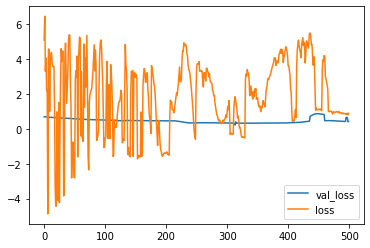

In [10]:
import gc
MC = ModelCheckpoint('./model.h5', verbose=True,monitor='val_loss',mode='min',
        save_weights_only=True,save_best_only=True)

stop = EarlyStopping(monitor = 'val_loss', restore_best_weights=True , patience = 5)

tr_it = iter(train_dataset)
batch_size = cfg['train_params']['train_batch']
#progress_bar = tqdm(range(0,cfg["train_params"]["max_num_steps"],batch_size))
progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))
two_hours = 60 * 60 * 3.1
losses = []
hist = []
for itr in progress_bar:#range(0,cfg["train_params"]["max_num_steps"],batch_size):
    inputs = np.zeros(shape=(batch_size,224,224,num_in_channels))
    targets = np.zeros(shape=(batch_size, num_targets))
    
    for i in range(batch_size):
        
        try:
            data = next(tr_it)
        except StopIteration:
            tr_it = iter(train_dataset)
            data = next(tr_it)
            
        inputs[i] = data['image'].transpose(1,2,0)
        targets[i] = data['target_positions'].reshape(-1,num_targets)
   
    h = model.fit(inputs, targets,
                  batch_size = int(batch_size / 2) ,
                  validation_data = (val_inputs, val_targets),
                  verbose = 1,
                 callbacks = [MC, stop])

    hist.append(h.history)
    gc.collect()
    # For training + submission, break if training exceeds 6 hours
    if (time.time()-t0) > two_hours:
        break
    #print(h.history['loss'][0])
    if h.history['loss'][0] < 1.3 and h.history['val_loss'][0] < 1.3:
        break
    
vl = [hi['val_loss'] for hi in hist]
l = [hi['loss'] for hi in hist]
plt.plot(np.log(vl), label = 'val_loss')
plt.plot(np.log(l), label = 'loss')
plt.legend(loc=0)
plt.show()

In [11]:
model.save('modelv0.h5')


In [ ]:
#this one if we need to load weights from h5
from numpy import loadtxt
from keras.models import load_model
from keras.applications.resnet50 import ResNet50
from keras.utils.conv_utils import convert_kernel
from keras.layers import (Input, Conv2D, Flatten,Dense,AveragePooling2D,Dropout,MaxPooling2D,BatchNormalization)
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
from keras.applications.resnet import ResNet101
# load model
model = load_model('modelv0.h5')
# summarize model.
model.summary()

/home/moriarty/.local/lib/python3.8/site-packages/l5kit/dataset/agent.py:115: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the future
  return self.get_frame(scene_index, state_index, track_id=track_id)


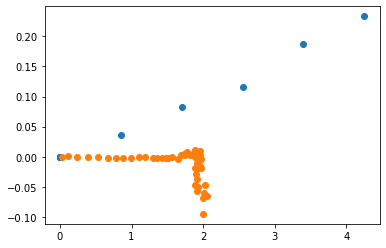

In [12]:
#Example Prediction:
import matplotlib.pyplot as plt
tr_it = iter(train_dataset)
a1 = next(tr_it)
inp = a1['image'].transpose(1,2,0)
act = a1['target_positions']
pred = model.predict(inp.reshape(-1,224,224,num_in_channels)).reshape(50,2)
plt.scatter(act[:,0], act[:,1])
plt.scatter(pred[:,0],pred[:,1])

Now we can use this model to predict from the test set.

In [13]:
test_cfg = cfg["test_data_loader"]

# Rasterizer
rasterizer = build_rasterizer(cfg, dm)

# Test dataset/dataloader
test_zarr = ChunkedDataset(dm.require(test_cfg["key"])).open()
test_mask = np.load(f"{DIR_INPUT}/scenes/mask.npz")["arr_0"]
test_dataset = AgentDataset(cfg, test_zarr, rasterizer, agents_mask=test_mask)

<ipython-input-13-540cf822d61a>:9: RuntimeWarning: you're running with a custom agents_mask
  test_dataset = AgentDataset(cfg, test_zarr, rasterizer, agents_mask=test_mask)


In [14]:
t_shape = test_dataset[0]["target_positions"].shape
timestamps = []
agent_ids = []
coords = []
for it in tqdm(test_dataset):
    
    dat = it['image'].transpose(1,2,0)
    coords.append(np.array(model.predict(dat.reshape(1,224,224,num_in_channels)).reshape(t_shape)))
    timestamps.append(it["timestamp"])
    agent_ids.append(it["track_id"])
    

100%|██████████| 71122/71122 [3:13:23<00:00,  6.13it/s]  


In [15]:
from l5kit.evaluation import write_pred_csv


write_pred_csv('submission.csv',
                timestamps = np.array(timestamps),
                track_ids = np.array(agent_ids),
                coords = np.array(coords) )